# analysis of DNA-MERFISH for Aire DNA

by Pu Zheng

2021.10.01


# Load basic functions

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

26660


# 0. fov parameters

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA',
             'save_folder':r'I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA_warpped',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':250,
                     'max_num_seeds': None,
                     'spot_seeding_th': 600,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             'ref_id': 0, # special for this experiment
             }


In [3]:
_fov_id = 4
# create fov class
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          )

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loadi

In [6]:
_overwrite_image = False

# 5. Process Protein images
fov.parallel=False
fov.protein_ref_id = 0
fov._process_image_to_spots('protein', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=True,
                            _fit_spots=False,
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=False,
                            _verbose=True)

# generate the dialated mask
# 2.0: create a seed mask from protein image Aire
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['protein']
    protein_ims = _grp['ims'][:]
    #protein_ids = _grp['ids'][:]
aire_im = protein_ims[0]
aire_mask = generate_analysis_mask(aire_im, snr_th=2.5)
dialate_size = 2
dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

_overwrite_image = False
_overwrite_spot = False
# 2. Process image into candidate spots
fov.parallel=True
fov.combo_ref_id = 0
fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _fit_in_mask=True,
                            _fitting_args={'seed_mask':dialated_mask},
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=False,
                            _verbose=True)

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_004.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_004.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_004.dax  in 5.998s
-- removing hot pixels for channels:['561'] in 8.617s
-- correct Z-shifts for channels:['561'] in 6.737s
-- illumination correction for channels: 561, in 2.560s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 24.744s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA_warpped\Conv_zscan_004.hdf5
++ base attributes saved:['protein_ref_im'] in 7.432s.
-- checking protein, region:[2 1] in 0.01

In [9]:
print(fov.save_filename)

I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA_warpped\Conv_zscan_004.hdf5


In [7]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    #combo_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


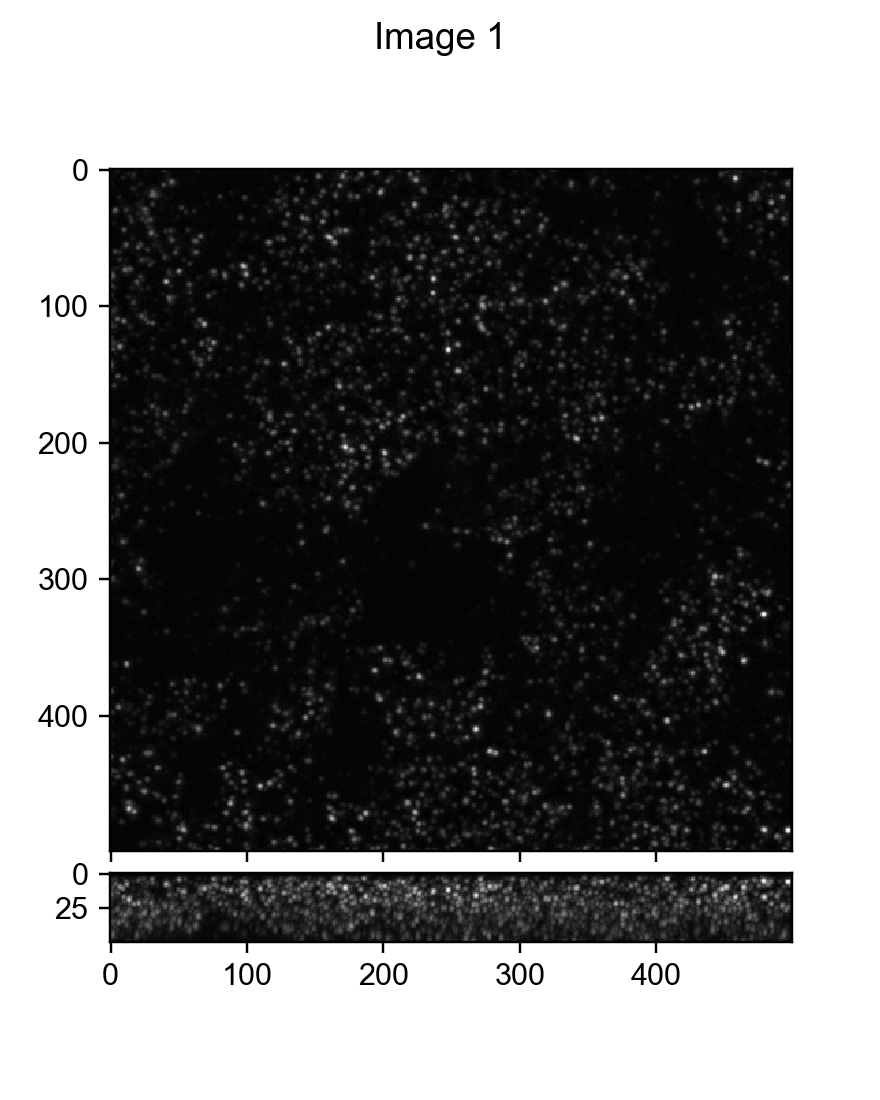

In [8]:
visual_tools.imshow_mark_3d_v2([combo_ims[0][:,500:1000,500:1000]])

In [4]:
from scipy import ndimage
from skimage import exposure
from skimage import morphology

#aire_im = protein_ims[0]

# Adaptive Equalization
#aire_adapteq_im = exposure.equalize_adapthist(aire_im, clip_limit=0.03)

def generate_analysis_mask(image, gaussian_size=6., snr_th=3):
    from scipy import ndimage
    # gaussian blur this image to ignore internal feature
    seg_im = ndimage.gaussian_filter(image.copy(), gaussian_size)
    seg_im = seg_im / io_tools.load.find_image_background(seg_im)
    mask = seg_im > snr_th
    return mask.astype(np.bool)

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['protein']
    protein_ims = _grp['ims'][:]
    #protein_ids = _grp['ids'][:]
aire_im = protein_ims[0]
aire_mask = generate_analysis_mask(aire_im, snr_th=2.5)
dialate_size = 3
dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [190]:
fov.color_dic

{'H0C1': ['c1', 'c2', 'beads', 'null', 'DAPI'],
 'H1C2': ['c3', 'c4', 'beads', 'null'],
 'H2C3': ['c5', 'c6', 'beads', 'null'],
 'H3C4': ['c7', 'c8', 'beads', 'null'],
 'H4C5': ['c9', 'c10', 'beads', 'null'],
 'H5C6': ['c11', 'c12', 'beads', 'null'],
 'H6C7': ['c13', 'c14', 'beads', 'null'],
 'H7C8': ['c15', 'c16', 'beads', 'null'],
 'H8C9': ['c17', 'c18', 'beads', 'null'],
 'H9C10': ['c19', 'c20', 'beads', 'null'],
 'H10C11': ['c21', 'c22', 'beads', 'null'],
 'H11C12': ['c23', 'c24', 'beads', 'null'],
 'H12C13': ['c25', 'c26', 'beads', 'null'],
 'H13C14': ['c27', 'c28', 'beads', 'null'],
 'H14C15': ['c29', 'c30', 'beads', 'null'],
 'H15C16': ['c31', 'c32', 'beads', 'null'],
 'H16C17': ['c33', 'c34', 'beads', 'null'],
 'H17C18': ['c35', 'c36', 'beads', 'null'],
 'H18C19': ['c37', 'c38', 'beads', 'null'],
 'H19C20': ['c39', 'c40', 'beads', 'null'],
 'H20C21': ['c41', 'c42', 'beads', 'null'],
 'H21C22': ['c43', 'c44', 'beads', 'null'],
 'H22C23': ['c45', 'c46', 'beads', 'null'],
 'H23C24

<IPython.core.display.Javascript object>


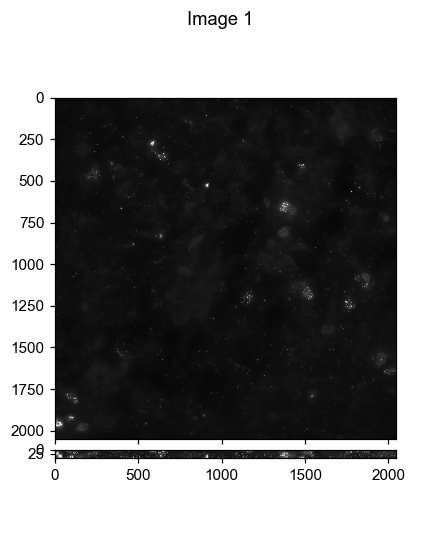

In [17]:
visual_tools.imshow_mark_3d_v2([aire_im, aire_mask, dialated_mask])

In [ ]:
_overwrite_image = False
fov_ids = np.arange(4,30)
#_fov_id = 0
# bad fov3
for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

    # generate the dialated mask
    # 2.0: create a seed mask from protein image Aire
    with h5py.File(fov.save_filename, "r", libver='latest') as _f:
        _grp = _f['protein']
        protein_ims = _grp['ims'][:]
        #protein_ids = _grp['ids'][:]
    aire_im = protein_ims[0]
    aire_mask = generate_analysis_mask(aire_im, snr_th=2.5)
    dialate_size = 2
    dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

    _overwrite_image = False
    _overwrite_spot = False
    # 2. Process image into candidate spots
    fov.parallel=True
    fov.combo_ref_id = 0
    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=True,
                                _fit_in_mask=True,
                                _fitting_args={'seed_mask':dialated_mask},
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=_overwrite_spot,
                                _verbose=True)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'protein_ref_im'] in 7.777s.
+ loading correction from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from sav

++ base attributes loaded:['combo_ref_im', 'dapi_im', 'protein_ref_im'] in 9.180s.
+ loading correction from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_006.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_006.hdf5
++ base attributes loaded:[] in 0.002s.
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_006.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'combo_ref_im', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'dapi_im', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', '

++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_008.hdf5
++ base attributes loaded:[] in 0.001s.
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_008.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'combo_ref_im', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'dapi_im', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'protein_ref_im', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi', 'verbo

In [5]:
# 2.0: create a seed mask from combo image Aire
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]


In [11]:
?np.save

In [12]:
figure_save_folder = r'\\10.245.74.158\Chromatin_NAS_6\Aire_Analysis\Aire_test_multifit'

for _i, _im in enumerate(combo_ims):
    _savename = os.path.join(figure_save_folder, os.path.basename(fov.save_filename).replace('.hdf5', f'_combo_{_i}'))
    np.save(_savename, _im)




<IPython.core.display.Javascript object>


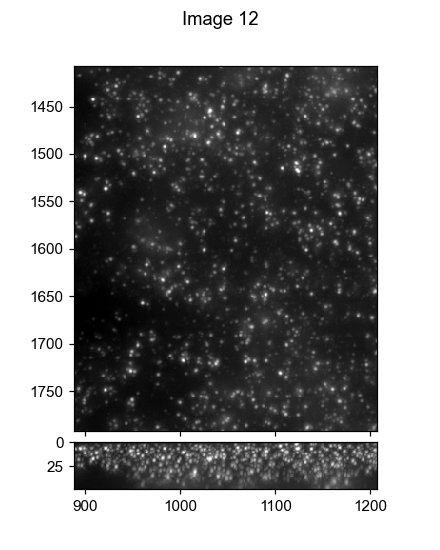

In [7]:
%matplotlib notebook

visual_tools.imshow_mark_3d_v2(combo_ims)

In [18]:
fov._load_from_file('combo', _overwrite=True)
for _spots in fov.combo_spots_list:
    print(len(_spots))

+ loading combo from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_004.hdf5
++ finish loading combo in 0.013s. 
303
715
163
392
170
317
197
296
159
325
171
318
62
230
204
390
189
378
168
373
151
427
175
396
184
382
134
416
128
353
144
143
206
277
215
388
175
303
178
433
154
351
155
310
192
470
109
293
170
396


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1630: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


In [19]:
# load codebook
import pandas as pd
codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-10_Aire\Summary_tables\CTP10-Aire_codebook.csv')
codebook.set_index('name')

,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,NDB_652,...,NDB_715,NDB_698,NDB_883,NDB_863,NDB_1033,NDB_878,NDB_631,NDB_758,NDB_1075,NDB_653
name,,,,,,,,,,,,,,,,,,,,,
Ccl21a,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Krt14,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Krt5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Col6a1,3,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Lifr,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ltf,204,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Clps,205,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Col1a1,206,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [152]:
from scipy.spatial.distance import cdist
from itertools import combinations
from tqdm import tqdm
dist_th=400

decoded_dict = {}

for _index in tqdm(codebook.index):
    _gene = codebook['name'][_index]
    _code = np.array(codebook.loc[_index, codebook.columns[2:]], dtype=np.int32)
    print('*', _gene)
    
    # for this code calculate pairwise distance
    sel_hzxys_list = []
    sel_spots_list = []
    onbits = np.where(_code)[0]
    for _onbit in onbits:

        _hzxys = fov.combo_spots_list[_onbit][:,:4].copy()
        _hzxys[:,1:4] = _hzxys[:,1:4] * fov.shared_parameters['distance_zxy']
        print(_onbit, len(_hzxys))
        sel_hzxys_list.append(_hzxys)
        sel_spots_list.append(fov.combo_spots_list[_onbit])

    # calculate all pairwise distance
    distance_dict = {}
    for _cb in combinations(list(onbits),2):
        print(_cb)
        distance_dict[_cb] = cdist(fov.combo_spots_list[_cb[0]][:,1:4]*fov.shared_parameters['distance_zxy'], 
                                   fov.combo_spots_list[_cb[1]][:,1:4]*fov.shared_parameters['distance_zxy'],)

    # find pairs within threshold
    sel_pairs_dict = {}
    for _cb, _dists in distance_dict.items():
        sel_pairs_dict[_cb] = np.where(_dists < dist_th)
        print(len(sel_pairs_dict[_cb][0]))

    onbit_table = {}
    sel_spot_df = pd.DataFrame(columns=list(onbits), index=[], dtype=np.int32)
    for _cb, _pairs in sel_pairs_dict.items():
        for _l,_r in zip(_pairs[0], _pairs[1]):
            if _l in np.array(sel_spot_df[_cb[0]]) and _r in np.array(sel_spot_df[_cb[1]]):
                #print(sel_spot_df.loc[sel_spot_df[_cb[0]]==_l],_l,_r)
                print(_l,_r)
                _l_loc = (sel_spot_df[_cb[0]]==_l)
                _r_loc = (sel_spot_df[_cb[1]]==_r)
                if (_l_loc == _r_loc).all():
                    pass
                else:
                    print('mixed pairs')
            elif _l in np.array(sel_spot_df[_cb[0]]) or _r in np.array(sel_spot_df[_cb[1]]):
                print('*',_l,_r, _cb)
                #print(sel_spot_df[list(_cb)])
                if _l in np.array(sel_spot_df[_cb[0]]):
                    print('left')
                    _loc = (sel_spot_df[_cb[0]]==_l)
                    sel_spot_df.loc[_loc,_cb[1]] = _r
                else:
                    print('right')
                    _loc = (sel_spot_df[_cb[1]]==_r)
                    sel_spot_df.loc[_loc,_cb[0]] = _l

            else:
                sel_spot_df=sel_spot_df.append({_cb[0]:_l, _cb[1]:_r}, ignore_index=True)

    # append intensity
    for _onbit in onbits:
        _int_list = []
        for _id in sel_spot_df[_onbit]:
            if np.isnan(_id):
                _int_list.append(np.nan)
            else:
                _int_list.append(fov.combo_spots_list[_onbit][int(_id), 0])

        sel_spot_df[f"{_onbit}_int"] = _int_list
    # append mean coordinates
    mean_coord_list = []
    for _onbit in onbits:
        _coord_list = []
        for _id in sel_spot_df[_onbit]:
            if np.isnan(_id):
                _coord_list.append(np.ones(3)*np.nan)
            else:
                _coord_list.append(fov.combo_spots_list[_onbit][int(_id), 1:4])
        mean_coord_list.append(_coord_list)
    mean_coord_list = np.nanmean(mean_coord_list, axis=0)
    sel_spot_df[['mean_z', 'mean_x', 'mean_y']] = mean_coord_list
    
    # append
    decoded_dict[_gene] = sel_spot_df

  1%|▊                                                                              | 2/209 [00:00<00:17, 11.55it/s]

* Ccl21a
7 296
26 134
35 388
(7, 26)
(7, 35)
(26, 35)
4
21
8
* 108 85 (7, 35)
left
28 85
* Krt14
23 396
34 215
47 293
(23, 34)
(23, 47)
(34, 47)
16
23
15
* 1 2 (23, 47)
left
* 10 7 (23, 47)
left
* 160 219 (23, 47)
left
* 182 131 (23, 47)
left
0 2
3 7
* 22 113 (34, 47)
right
* 151 148 (34, 47)
left
155 131
* 173 15 (34, 47)
left
* Krt5
13 230
17 378
34 215
(13, 17)


  1%|█▏                                                                             | 3/209 [00:00<00:18, 10.89it/s]

(13, 34)
(17, 34)
19
16
14
* 17 43 (13, 34)
left
* 41 67 (13, 34)
left
* 76 166 (13, 34)
left
* 147 64 (13, 34)
left
26 43
61 67
* 85 154 (17, 34)
right
222 166
* Col6a1
2 163
23 396
43 310
(2, 23)
(2, 43)
(23, 43)
12
11
20
* Lifr
2 163
26 134
38 178
(2, 26)
(2, 38)
(26, 38)
6
2
5
*

  3%|██▋                                                                            | 7/209 [00:00<00:16, 12.10it/s]

 80 113 (26, 38)
left
* Itga6
16 189
22 175
49 396
(16, 22)
(16, 49)
(22, 49)
10
18
9
* 45 14 (16, 49)
left
* 125 64 (16, 49)
left
* 6 61 (22, 49)
left
29 14
* 30 100 (22, 49)
right
* 107 65 (22, 49)
left
* Col4a1
9 325
10 171
41 351
(9, 10)
(9, 41)
(10, 41)
10
29
9
* 68 15 (9, 41)
left
* 108 42 (9, 41)
left
* 122 82 (9, 41)
left
* 170 148 (9, 41)
left
47 15
102 42
166 148
* Ascl1
26 134
29 353
41 351
(26, 29)
(26, 41)
(29, 41)
6
9
24
*

  4%|███▍                                                                           | 9/209 [00:00<00:17, 11.74it/s]

 5 4 (26, 41)
left
* 73 37 (26, 41)
left
20 4
* 33 220 (29, 41)
left
* 51 185 (29, 41)
left
* 105 84 (29, 41)
left
* 344 112 (29, 41)
left
* Cald1
10 171
23 396
39 433
(10, 23)
(10, 39)
(23, 39)
16
6
33
* 31 130 (10, 39)
left
* 62 177 (10, 39)
left
* 82 128 (10, 39)
left
* 85 96 (10, 39)
left
46 96
50 177
52 130
98 128
* 114 140 (23, 39)
left
* Krt17
7 296
48 170
49 396
(7, 48)
(7, 49)
(48, 49)
13
24
13
* 7 23 (7, 49)
left
* 8 12 (7, 49)
left
*

  5%|████                                                                          | 11/209 [00:00<00:17, 11.62it/s]

 27 36 (7, 49)
left
* 90 64 (7, 49)
left
* 123 156 (7, 49)
left
5 12
29 64
32 23
45 36
* C3
9 325
20 151
27 416
(9, 20)
(9, 27)
(20, 27)
7
23
10
* 76 22 (9, 27)
left
* 308 95 (9, 27)
right
28 22
* Trp63
17 378
32 206
40 154
(17, 32)
(17, 40)
(32, 40)
21
16
10
* 25 13 (17, 40)
left
* 102 66 (17, 40)
left
52 13
85 66
* 146 114 (32, 40)
left


  6%|████▊                                                                         | 13/209 [00:01<00:19, 10.24it/s]

* Dclk1
1 715
6 197
13 230
(1, 6)
(1, 13)
(6, 13)
38
30
14
* 156 82 (1, 6)
right
* 28 88 (1, 13)
left
* 91 44 (1, 13)
left
* 151 58 (1, 13)
left
* 196 149 (1, 13)
left
* 429 132 (1, 13)
left
16 149
19 88
110 132
* 151 63 (6, 13)
right
* Trpm5
6 197
37 303
43 310
(6, 37)
(6, 43)
(37, 43)
15
12
24
* 125 198 (6, 37)
left
*

  7%|█████▌                                                                        | 15/209 [00:01<00:17, 11.03it/s]

 14 13 (6, 43)
left
* 16 40 (6, 43)
left
* 51 26 (6, 43)
left
* 111 141 (6, 43)
left
* 123 63 (6, 43)
left
* 149 98 (6, 43)
left
20 13
23 40
29 26
56 63
* 80 33 (37, 43)
left
92 98
* Ly6g6f
3 392
12 62
31 143
(3, 12)
(3, 31)
(12, 31)
7
13
9
* 28 55 (3, 12)
left
* 7 43 (3, 31)
left
* 15 68 (3, 31)
left
* 23 35 (3, 31)
left
* 28 70 (3, 31)
left
8 35
35 43
* 48 130 (12, 31)
left
* 51 70 (12, 31)
right
52 68
* 55 70 (12, 31)
right
* Avil
11 318
15 390
49 396
(11, 15)
(11, 49)
(15, 49)
23
19
30
* 37 115 (11, 49)
left
* 43 123 (11, 49)
left
* 87 354 (11, 49)
left
* 109 320 (11, 49)
left
* 163 126 (11, 49)
left
* 272 187 (11, 49)
left
* 27 360 (15, 49)
right
39 115
51 123
* 59 35 (15, 49)
left
* 153 146 (15, 49)
right
171 126
* 226 316 (15, 49)
left


  8%|██████▎                                                                       | 17/209 [00:01<00:18, 10.51it/s]

* Alox5ap
9 325
38 178
44 192
(9, 38)
(9, 44)
(38, 44)
12
16
11
* 3 3 (9, 44)
left
* 26 27 (9, 44)
left
* 38 41 (9, 44)
left
* 112 153 (9, 44)
left
* 158 37 (9, 44)
left
4 3
28 27
41 41
118 37
119 153
* 154 175 (38, 44)
left
* Hck
0 303
17 378
28 128
(0, 17)
(0, 28)
(17, 28)
29
17
15
* 106 87 (0, 28)
left
* 114 60 (0, 28)
right
* 168 9 (0, 28)
left
* 209 93 (0, 28)
left
* 258 49 (0, 28)
right
* 7 8 (17, 28)
left
* 101 99 (17, 28)
left
115 9
146 99
mixed pairs
269 93
*

  9%|███████                                                                       | 19/209 [00:01<00:18, 10.41it/s]

 297 31 (17, 28)
right
* Plk2
5 317
13 230
22 175
(5, 13)
(5, 22)
(13, 22)
19
11
12
* 137 152 (5, 13)
right
* 44 71 (5, 22)
left
* 71 84 (5, 22)
left
* 107 99 (5, 22)
left
* 118 46 (5, 22)
left
* 137 127 (5, 22)
left
* 21 25 (13, 22)
right
75 99
152 127
215 71
* Pik3r5
27 416
46 109
47 293
(27, 46)
(27, 47)
(46, 47)
10
27
5
* 63 20 (27, 47)
left
* 80 69 (27, 47)
left
* 80 72 (27, 47)
left
11 20
54 72
* Agt
6 197
29 353
34 215
(6, 29)
(6, 34)
(29, 34)
13
26
23
* 13 4 (6, 34)
left
*

 11%|████████▌                                                                     | 23/209 [00:02<00:15, 11.91it/s]

 64 35 (6, 34)
left
* 92 9 (6, 34)
left
* 187 106 (6, 34)
left
6 4
* 11 98 (29, 34)
right
* 19 4 (29, 34)
right
24 35
* 43 98 (29, 34)
right
104 106
332 9
* Nrgn
5 317
25 382
42 155
(5, 25)
(5, 42)
(25, 42)
11
12
7
* 23 38 (5, 42)
right
* 25 22 (5, 42)
left
* 63 20 (5, 42)
left
39 22
48 20
* Plac8
7 296
12 62
20 151
(7, 12)
(7, 20)
(12, 20)
6
8
10
* 15 91 (7, 20)
left
* 16 51 (7, 20)
left
* 26 62 (7, 20)
left
* 53 64 (7, 20)
left
* 3 9 (12, 20)
left
29 51
* 34 48 (12, 20)
right
36 62
47 64
50 91
* Fxyd6
11 318
34 215
46 109
(11, 34)
(11, 46)
(34, 46)
9
7
9
* 24 38 (11, 46)
left
* 27 25 (11, 46)
left
22 38
63 25
* Pou2f3
33 277
40 154
47 293
(33, 40)
(33, 47)
(40, 47)
11
23
11
*

 12%|█████████▎                                                                    | 25/209 [00:02<00:14, 12.53it/s]

 207 58 (33, 40)
left
* 74 48 (33, 47)
left
* 82 113 (33, 47)
left
74 48
* 81 123 (40, 47)
left
* Ccl20
3 392
13 230
33 277
(3, 13)
(3, 33)
(13, 33)
22
20
19
* 45 70 (3, 33)
left
* 48 61 (3, 33)
left
* 53 36 (3, 33)
left
* 87 96 (3, 33)
left
* 91 58 (3, 33)
left
* 164 213 (3, 33)
left
* 266 31 (3, 33)
left
61 36
86 213
90 31
106 96
108 70
148 58
* Ccl9
14 204
37 303
48 170
(14, 37)
(14, 48)
(37, 48)
18
19
15
* 65 127 (14, 37)
left
* 1 38 (14, 48)
left
* 14 72 (14, 48)
left
* 19 46 (14, 48)
left
* 29 40 (14, 48)
left
* 42 57 (14, 48)
left
* 51 134 (14, 48)
left
* 65 79 (14, 48)
left
*

 14%|██████████▊                                                                   | 29/209 [00:02<00:15, 11.81it/s]

 106 20 (14, 48)
left
34 38
38 46
61 40
66 134
* 80 95 (37, 48)
right
88 79
mixed pairs
127 79
181 20
239 72
* Ccl6
7 296
28 128
43 310
(7, 28)
(7, 43)
(28, 43)
19
17
12
* 17 14 (7, 43)
left
* 25 29 (7, 43)
left
* 29 33 (7, 43)
left
* 39 61 (7, 43)
left
* 66 56 (7, 43)
left
* 91 1 (7, 43)
left
* 103 48 (7, 43)
left
26 33
49 56
52 14
57 61
70 29
76 48
* 117 178 (28, 43)
left
* Rnase1
10 171
46 109
49 396
(10, 46)
(10, 49)
(46, 49)
10
18
11
* 67 139 (10, 49)
left
* 140 137 (10, 49)
left
* 162 354 (10, 49)
left
* 52 169 (46, 49)
left
64 139
105 137
* Gp2
11 318
16 189
27 416
(11, 16)
(11, 27)
(16, 27)
16
25
23
*

 15%|███████████▌                                                                  | 31/209 [00:02<00:15, 11.14it/s]

 44 100 (11, 27)
left
* 66 55 (11, 27)
left
* 78 324 (11, 27)
left
* 133 114 (11, 27)
right
94 55
113 324
136 100
* Fabp1
11 318
44 192
47 293
(11, 44)
(11, 47)
(44, 47)
10
19
11
* 80 70 (11, 47)
left
* 85 233 (11, 47)
right
136 70
* 182 97 (44, 47)
left
* Sox8
4 170
23 396
38 178
(4, 23)
(4, 38)
(23, 38)
12
10
13
* 139 125 (4, 23)
left
* 80 106 (4, 38)
left
* 112 137 (4, 38)
left
* 118 85 (4, 38)
left
* 139 123 (4, 38)
left
* 100 174 (23, 38)
right
151 137
* Spib
8 159
45 470
46 109
(8, 45)
(8, 46)
(45, 46)
16
12
12
*

 16%|████████████▎                                                                 | 33/209 [00:02<00:14, 11.91it/s]

 14 4 (8, 46)
left
* 43 91 (8, 46)
left
* 64 66 (8, 46)
left
* 67 28 (8, 46)
left
* 72 39 (8, 46)
left
14 4
* 24 18 (45, 46)
right
49 66
50 91
63 28
201 78
mixed pairs
* Fxyd3
6 197
24 184
26 134
(6, 24)
(6, 26)
(24, 26)
17
15
12
* 15 2 (6, 26)
left
* 33 57 (6, 26)
left
* 44 33 (6, 26)
left
* 48 46 (6, 26)
left
* 86 40 (6, 26)
left
* 95 100 (6, 26)
left
* 140 102 (6, 26)
left
0 2
55 33
60 40
68 46
124 100
151 102
* Tnfrsf11b
20 151
33 277
37 303
(20, 33)
(20, 37)
(33, 37)
2
14
22
* 115 63 (20, 37)
left
129 63


 17%|█████████████                                                                 | 35/209 [00:03<00:14, 12.14it/s]

* Ifi27l2b
28 128
35 388
49 396
(28, 35)
(28, 49)
(35, 49)
16
12
32
* 21 19 (28, 49)
left
* 35 64 (28, 49)
left
* 61 23 (28, 49)
left
* 91 109 (28, 49)
left
* 111 192 (28, 49)
left
11 23
25 19
38 109
* 55 170 (35, 49)
right
* 252 236 (35, 49)
left
* Guca2a
16 189
19 373
21 427
(16, 19)
(16, 21)
(19, 21)
21
20
30
* 2 0 (16, 21)
left
* 19 18 (16, 21)
left
* 27 9 (16, 21)
left
* 35 23 (16, 21)
left
* 37 92 (16, 21)
left
* 43 32 (16, 21)
left
* 52 15 (16, 21)
left
*

 19%|██████████████▌                                                               | 39/209 [00:03<00:14, 12.00it/s]

 89 121 (16, 21)
left
* 99 73 (16, 21)
left
* 156 63 (16, 21)
left
8 9
19 32
30 18
32 0
57 73
78 23
* 125 138 (19, 21)
left
* 154 172 (19, 21)
left
* Pigr
2 163
11 318
28 128
(2, 11)
(2, 28)
(11, 28)
5
7
7
* 226 91 (11, 28)
right
* Muc13
6 197
25 382
46 109
(6, 25)
(6, 46)
(25, 46)
20
8
8
* 40 26 (6, 46)
left
* 109 60 (6, 46)
left
* 33 24 (25, 46)
right
59 26
70 60
* Saa1
2 163
34 215
48 170
(2, 34)
(2, 48)
(34, 48)
7
8
13
* 18 27 (2, 48)
left
* 25 68 (2, 48)
left
* 36 23 (2, 48)
left
51 27
61 68
92 23
* 163 159 (34, 48)
left
* Aldob
11 318
22 175
43 310
(11, 22)
(11, 43)
(22, 43)
13
17
15
*

 21%|████████████████                                                              | 43/209 [00:03<00:13, 12.44it/s]

 10 4 (11, 43)
left
* 12 18 (11, 43)
left
* 54 75 (11, 43)
left
* 58 96 (11, 43)
left
8 4
10 18
56 75
88 96
* Lgals2
19 373
22 175
25 382
(19, 22)
(19, 25)
(22, 25)
21
28
15
* 1 6 (19, 25)
left
* 5 88 (19, 25)
left
* 27 38 (19, 25)
left
* 77 124 (19, 25)
left
* 91 77 (19, 25)
left
* 191 272 (19, 25)
left
* 222 159 (19, 25)
left
1 6
* 13 129 (22, 25)
left
* 44 124 (22, 25)
right
65 38
92 159
109 272
167 77
* Gsta2
12 62
24 184
43 310
(12, 24)
(12, 43)
(24, 43)
6
2
12
* 96 138 (24, 43)
left
* Lcn2
6 197
19 373
41 351
(6, 19)
(6, 41)
(19, 41)
21
19
24
*

 22%|████████████████▊                                                             | 45/209 [00:03<00:15, 10.56it/s]

 102 101 (6, 19)
left
* 8 9 (6, 41)
left
* 55 80 (6, 41)
left
* 71 58 (6, 41)
left
* 78 81 (6, 41)
left
* 102 43 (6, 41)
left
* 108 76 (6, 41)
left
9 9
34 80
37 76
58 58
* 62 197 (19, 41)
left
* 70 99 (19, 41)
left
* 89 292 (19, 41)
left
101 43
* 247 337 (19, 41)
right
* Apoa1
9 325
19 373
29 353
(9, 19)
(9, 29)
(19, 29)
23
27
26
* 201 240 (9, 19)
right
* 28 70 (9, 29)
left
* 35 36 (9, 29)
left
* 57 61 (9, 29)
left
* 65 67 (9, 29)
left
* 85 251 (9, 29)
left
* 143 98 (9, 29)
left
* 143 342 (9, 29)
left
* 182 216 (9, 29)
left
201 289
mixed pairs
42 70
45 36
66 67
103 61
* 161 274 (19, 29)
left
190 216
* 192 98 (19, 29)
left
* 192 342 (19, 29)
left
240 289
mixed pairs
* 295 347 (19, 29)
left
* Hnf4a
35 388
44 192
46 109
(35, 44)
(35, 46)
(44, 46)
21
13


 22%|█████████████████▌                                                            | 47/209 [00:04<00:13, 11.63it/s]

12
* 41 30 (35, 44)
right
* 15 14 (35, 46)
left
* 36 22 (35, 46)
left
* 68 49 (35, 46)
left
* 181 88 (35, 46)
left
* 202 106 (35, 46)
left
* 30 31 (44, 46)
left
* 30 42 (44, 46)
left
46 22
49 14
85 49
92 88
122 106
* Hnf4g
7 296
33 277
46 109
(7, 33)
(7, 46)
(33, 46)
12
7
3
* 45 30 (7, 46)
left
30 30
* 39 17 (33, 46)
right
* Igf1
13 230
27 416
45 470
(13, 27)
(13, 45)
(27, 45)
25
30
26
* 55 242 (13, 27)
right
* 3 4 (13, 45)
left
* 10 39 (13, 45)
left
41 44
mixed pairs
* 62 43 (13, 45)
left
* 65 73 (13, 45)
left
* 97 181 (13, 45)
left
* 202 170 (13, 45)
left
2 4
* 17 113 (27, 45)
right
31

 23%|██████████████████▎                                                           | 49/209 [00:04<00:16,  9.74it/s]

 39
* 47 13 (27, 45)
left
60 43
66 73
* 98 126 (27, 45)
left
121 170
152 181
* 181 154 (27, 45)
right
* Grhl1
3 392
21 427
47 293
(3, 21)
(3, 47)
(21, 47)
27
29
15
* 70 72 (3, 47)
left
* 92 93 (3, 47)
left
* 188 128 (3, 47)
left
* 258 205 (3, 47)
left
* 327 172 (3, 47)
left
100 93
121 72
135 172
186 128
* Lypd3
20 151
35 388
41 351
(20, 35)
(20, 41)
(35, 41)
6
9
18
* 5 1 (20, 41)
left
* 54 146 (20, 41)
left
* 96 107 (20, 41)
left
4 1
81 146
*

 24%|███████████████████                                                           | 51/209 [00:04<00:15, 10.25it/s]

 208 108 (35, 41)
right
* Krtdap
19 373
36 175
43 310
(19, 36)
(19, 43)
(36, 43)
12
26
14
* 108 58 (19, 43)
left
* 160 132 (19, 43)
left
* 46 80 (36, 43)
left
87 58
113 132
* Tacstd2
2 163
25 382
29 353
(2, 25)
(2, 29)
(25, 29)
5
9
24
* 116 268 (2, 29)
left
* 241 268 (25, 29)
right


 25%|███████████████████▊                                                          | 53/209 [00:04<00:13, 11.55it/s]

* Krt16
12 62
13 230
41 351
(12, 13)
(12, 41)
(13, 41)
2
4
14
* 57 37 (12, 41)
left
3 37
* 5 110 (13, 41)
right
* Pdzk1ip1
17 378
37 303
44 192
(17, 37)
(17, 44)
(37, 44)
30
17
14
* 6 17 (17, 44)
left
* 62 31 (17, 44)
left
* 68 26 (17, 44)
left
* 106 6 (17, 44)
left
* 121 32 (17, 44)
left
12 17
57 26
86 6
109 32
* 113 68 (37, 44)
right
* 158 38 (37, 44)
left
* Tmem45a
21 427
34 215
41 351
(21, 34)
(21, 41)
(34, 41)
15
19
15
*

 27%|█████████████████████▎                                                        | 57/209 [00:05<00:13, 11.23it/s]

 11 135 (21, 41)
left
* 189 204 (21, 41)
left
6 135
* 40 96 (34, 41)
left
152 204
* Krt10
2 163
3 392
6 197
(2, 3)
(2, 6)
(3, 6)
11
5
16
* 15 3 (2, 6)
left
3 3
* Gm94
5 317
32 206
36 175
(5, 32)
(5, 36)
(32, 36)
24
14
15
* 1 9 (5, 36)
left
* 4 98 (5, 36)
left
* 11 124 (5, 36)
left
* 24 127 (5, 36)
left
* 154 130 (5, 36)
left
3 9
14 98
* 15 58 (32, 36)
left
* 19 18 (32, 36)
left
* 48 55 (32, 36)
left
* 66 73 (32, 36)
left
* 90 36 (32, 36)
right
102 130
109 124
* Acpp
31 143
35 388
45 470
(31, 35)


 28%|██████████████████████                                                        | 59/209 [00:05<00:13, 11.34it/s]

(31, 45)
(35, 45)
15
16
22
* 85 110 (31, 35)
right
* 2 129 (31, 45)
left
* 7 0 (31, 45)
left
* 17 7 (31, 45)
left
85 153
mixed pairs
1 0
13 7
110 153
mixed pairs
111 129
* 154 144 (35, 45)
right
* Cnfn
10 171
17 378
22 175
(10, 17)
(10, 22)
(17, 22)
14
11
13
* 10 15 (10, 22)
left
* 16 16 (10, 22)
left
* 99 49 (10, 22)
left
* 100 43 (10, 22)
left
15 16
19 15
20 43
* 129 61 (17, 22)
left
249 49
* Fam25c
1 715
9 325
30 144
(1, 9)
(1, 30)
(9, 30)
38
26
14
*

 29%|██████████████████████▊                                                       | 61/209 [00:05<00:14, 10.52it/s]

 129 27 (1, 9)
right
* 467 277 (1, 9)
left
* 25 17 (1, 30)
left
* 30 125 (1, 30)
left
* 40 19 (1, 30)
left
* 68 39 (1, 30)
left
* 103 66 (1, 30)
left
* 140 33 (1, 30)
left
7 19
11 17
27 5
mixed pairs
61 66
84 33
135 39
* Elovl4
3 392
17 378
26 134
(3, 17)
(3, 26)
(17, 26)
19
7
9
* Efna3
14 204
18 168
35 388
(14, 18)
(14, 35)
(18, 35)
18
15
16
* 96 44 (14, 18)
right
* 50 26 (14, 35)
left
* 68 62 (14, 35)
left
* 79 63 (14, 35)
left
96

 30%|███████████████████████▌                                                      | 63/209 [00:05<00:14, 10.29it/s]

 61
mixed pairs
* 97 94 (14, 35)
left
* 106 8 (14, 35)
left
* 180 83 (14, 35)
left
32 26
34 62
44 61
mixed pairs
* 54 53 (18, 35)
left
59 63
70 8
114 94
123 83
* Cebpb
10 171
11 318
45 470
(10, 11)
(10, 45)
(11, 45)
11
20
28
* 4 85 (10, 11)
left
* 4 1 (10, 45)
left
* 26 12 (10, 45)
left
* 162 99 (10, 45)
left
* 7 1 (11, 45)
right
33 12
* 85 1 (11, 45)
right
87 99
* Ly6d
1 715
16 189
48 170
(1, 16)
(1, 48)
(16, 48)
17
20
14
* 0 68 (1, 48)
left
* 19 9 (1, 48)
left
* 35 47 (1, 48)
left
* 77 43 (1, 48)
left
8

 32%|█████████████████████████                                                     | 67/209 [00:05<00:11, 12.44it/s]

 47
11 43
34 9
50 68
* 71 58 (16, 48)
left
* 125 29 (16, 48)
right
* Gsta4
16 189
20 151
30 144
(16, 20)
(16, 30)
(20, 30)
8
2
4
* 10 6 (16, 30)
left
17 6
* Serpinb11
0 303
42 155
43 310
(0, 42)
(0, 43)
(42, 43)
9
13
10
* 44 34 (0, 43)
left
* 157 76 (0, 43)
left
* 220 115 (0, 43)
left
* 281 109 (0, 43)
right
* 1 0 (42, 43)
left
28 76
35 34
85 115
* Gabrp
9 325
22 175
40 154
(9, 22)
(9, 40)
(22, 40)
14
11
5
* 14 18 (9, 40)
left
17 18
* Cyp2f2
0 303
7 296
8 159
(0, 7)
(0, 8)
(7, 8)
20
16
8
*

 33%|█████████████████████████▊                                                    | 69/209 [00:06<00:11, 12.39it/s]

 26 13 (0, 8)
left
* 112 114 (0, 8)
left
* 194 91 (0, 8)
left
13 13
* 57 18 (7, 8)
left
86 91
* Gsto1
29 353
40 154
43 310
(29, 40)
(29, 43)
(40, 43)
7
20
8
* 43 33 (29, 43)
right
* Anxa8
21 427
28 128
37 303
(21, 28)
(21, 37)
(28, 37)
10
27
10
* 11 0 (21, 37)
left
* 29 49 (21, 37)
left
* 52 65 (21, 37)
left
* 53 47 (21, 37)
left
* 210 78 (21, 37)
left
3 0
40 65
78 47
88 49
* Mlph
5 317
7 296
17 378
(5, 7)
(5, 17)
(7, 17)
25
27
27
* 23 98 (5, 7)
right
*

 34%|██████████████████████████▍                                                   | 71/209 [00:06<00:12, 10.86it/s]

 25 65 (5, 17)
left
* 43 57 (5, 17)
left
* 59 26 (5, 17)
left
* 110 74 (5, 17)
left
* 155 279 (5, 17)
left
* 161 132 (5, 17)
left
* 216 359 (5, 17)
left
19 26
42 57
78 132
82 74
* 85 26 (7, 17)
right
* 132 25 (7, 17)
right
167 279
202 359
* Cd14
12 62
21 427
35 388
(12, 21)
(12, 35)
(21, 35)
10
3
26
* 44 190 (12, 21)
left
* 55 273 (12, 21)
right
* 37 88 (12, 35)
left
95 88
* 206 264 (21, 35)
left
* 228 264 (21, 35)
right
* Foxa1
1 715
5 317
11 318
(1, 5)
(1, 11)
(5, 11)
26
25
17
*

 35%|███████████████████████████▏                                                  | 73/209 [00:06<00:13, 10.37it/s]

 46 32 (1, 11)
left
* 113 71 (1, 11)
left
* 204 68 (1, 11)
left
90 68
123 32
138 135
mixed pairs
* 171 141 (5, 11)
left
* 191 165 (5, 11)
left
* 198 213 (5, 11)
right
203 71
* Ttc36
10 171
14 204
15 390
(10, 14)
(10, 15)
(14, 15)
15
18
15
* 7 27 (10, 15)
left
* 23 40 (10, 15)
left
* 44 162 (10, 15)
left
* 57 25 (10, 15)
left
* 75 61 (10, 15)
left
* 168 112 (10, 15)
left
16 27
30 40
76 25
77 61
* 81 16 (14, 15)
right
* 108 36 (14, 15)
left
123 112
* 125 85 (14, 15)
left
137 162
* 195 369 (14, 15)
left
* Foxj1
15 390
19 373
44 192
(15, 19)
(15, 44)
(19, 44)
30
19
15
* 1 11 (15, 44)
left
* 2 13 (15, 44)
left
* 20 29 (15, 44)
left
* 47 107 (15, 44)
left
* 56 44 (15, 44)
left
* 72 78 (15, 44)
left
*

 36%|███████████████████████████▉                                                  | 75/209 [00:06<00:13, 10.17it/s]

 204 113 (15, 44)
left
* 247 108 (15, 44)
right
* 262 44 (15, 44)
right
2 11
31 29
50 13
53 44
73 107
* 127 115 (19, 44)
right
165 113
* Fam183b
1 715
3 392
20 151
(1, 3)
(1, 20)
(3, 20)
48
17
5
* 121 122 (1, 20)
left
* 276 108 (3, 20)
right
* Ccdc30
6 197
14 204
49 396
(6, 14)
(6, 49)
(14, 49)
20
21
18
* 9 3 (6, 49)
left
*

 37%|████████████████████████████▋                                                 | 77/209 [00:06<00:14,  9.38it/s]

 26 27 (6, 49)
left
* 43 296 (6, 49)
left
* 50 16 (6, 49)
left
* 92 18 (6, 49)
left
* 117 100 (6, 49)
left
* 122 131 (6, 49)
left
* 137 78 (6, 49)
left
7 27
9 3
11 16
* 20 48 (14, 49)
right
55 78
61 18
85 100
131 131
* Meig1
14 204
20 151
43 310
(14, 20)
(14, 43)
(20, 43)
6
11
6
* 29 24 (20, 43)
right
* Spag8
1 715
18 168
29 353
(1, 18)
(1, 29)
(18, 29)
30
32
12
*

 39%|██████████████████████████████▏                                               | 81/209 [00:07<00:12, 10.44it/s]

 49 90 (1, 29)
left
* 120 108 (1, 29)
left
* 124 64 (1, 29)
left
7 108
* 47 47 (18, 29)
right
50 64
73 90
* 120 58 (18, 29)
left
* 128 156 (18, 29)
right
* Vpreb3
16 189
17 378
36 175
(16, 17)
(16, 36)
(17, 36)
15
17
13
* 20 42 (16, 36)
left
* 44 35 (16, 36)
left
* 46 69 (16, 36)
left
* 102 59 (16, 36)
left
* 148 138 (16, 36)
left
17 42
24 69
46 35
54 59
159 138
* Riiad1
11 318
26 134
40 154
(11, 26)
(11, 40)
(26, 40)
8
13
12
* 50 102 (11, 40)
left
* 65 54 (11, 40)
left
* 76 93 (11, 40)
left
47 54
64 102
75 93
* 119 59 (26, 40)
right
* Rsph1
25 382
37 303
45 470
(25, 37)
(25, 45)
(37, 45)
17
27
26


 40%|██████████████████████████████▉                                               | 83/209 [00:07<00:12,  9.83it/s]

* 10 5 (25, 45)
left
* 18 46 (25, 45)
left
* 22 20 (25, 45)
left
* 23 75 (25, 45)
left
* 82 80 (25, 45)
left
* 104 71 (25, 45)
left
* 348 155 (25, 45)
left
2 5
25 20
40 46
50 75
52 71
74 80
* 116 128 (37, 45)
right
180 155
* Odf3b
41 351
42 155
47 293
(41, 42)
(41, 47)
(42, 47)
14
25
15
* 7 8 (41, 47)
left
* 10 36 (41, 47)
left
* 63 60 (41, 47)
left
* 109 58 (41, 47)
left
* 116 78 (41, 47)
left
* 135 5 (41, 47)
left
* 184 35 (41, 47)
left
* 211 131 (41, 47)
left
0 5
14 8
* 23 9 (42, 47)
left
33 36
* 69 71 (42, 47)
right
76 131
87 35
104 58
117 78
* Car8
12 62
38 178
46 109
(12, 38)
(12, 46)
(38, 46)
1
2
7
* Rnase4
7 296
32 206
44 192
(7, 32)
(7, 44)
(32, 44)
21
14
10
*

 41%|███████████████████████████████▋                                              | 85/209 [00:07<00:10, 11.42it/s]

 4 152 (7, 44)
left
* 18 34 (7, 44)
left
* 33 161 (7, 44)
left
9 152
* 34 83 (32, 44)
right
64 34
112 161
* 188 156 (32, 44)
left
* Tspan1
4 170
25 382
47 293
(4, 25)
(4, 47)
(25, 47)
10
11
25
* 77 17 (4, 47)
left
20 17
* Stxbp5l
14 204
16 189
23 396
(14, 16)
(14, 23)
(16, 23)
19
18
26
* 7 119 (14, 23)
left
* 22 20 (14, 23)
left
* 56 67 (14, 23)
left
* 111 76 (14, 23)
left
* 118 117 (14, 23)
left
* 174 73 (14, 23)
left
21 20
82 67
*

 43%|█████████████████████████████████▏                                            | 89/209 [00:08<00:10, 11.46it/s]

 92 88 (16, 23)
left
93 117
95 76
* 125 24 (16, 23)
right
148 119
* 157 33 (16, 23)
right
159 73
* Igfbp5
9 325
26 134
47 293
(9, 26)
(9, 47)
(26, 47)
8
24
7
* 17 44 (9, 47)
left
* 18 28 (9, 47)
left
* 97 67 (9, 47)
left
24 28
32 44
49 67
* Cpn1
6 197
17 378
20 151
(6, 17)
(6, 20)
(17, 20)
15
12
11
* 6 32 (6, 20)
left
* 47 3 (6, 20)
left
* 76 13 (6, 20)
left
8 32
71 13
* 95 109 (17, 20)
right
* Rap1gap2
10 171
21 427
29 353
(10, 21)
(10, 29)
(21, 29)
8
14
23
* 29 121 (10, 21)
left
* 32 31 (10, 29)
left
31

 44%|█████████████████████████████████▉                                            | 91/209 [00:08<00:09, 12.45it/s]

 31
* 89 177 (21, 29)
right
* Celf3
12 62
28 128
47 293
(12, 28)
(12, 47)
(28, 47)
3
2
10
* Syt7
39 433
45 470
47 293
(39, 45)
(39, 47)
(45, 47)
36
20
26
* 16 27 (39, 47)
left
* 44 6 (39, 47)
left
* 58 40 (39, 47)
left
* 87 110 (39, 47)
left
* 118 102 (39, 47)
left
* 422 237 (39, 47)
left
* 1 233 (45, 47)
right
42 27
59 6
72 40
109 110
164 237
* 195 259 (45, 47)
right
* 371 171 (45, 47)
right


 44%|██████████████████████████████████▋                                           | 93/209 [00:08<00:10, 11.32it/s]

* Gpx3
10 171
34 215
42 155
(10, 34)
(10, 42)
(34, 42)
14
6
10
* 22 60 (10, 42)
left
* 80 84 (10, 42)
left
61 60
110 84
* Foxa3
26 134
44 192
45 470
(26, 44)
(26, 45)
(44, 45)
12
18
22
* 10 11 (26, 45)
left
* 42 71 (26, 45)
left
* 62 189 (26, 45)
left
9 11
* 120 119 (44, 45)
left
162 189
* Foxa2
12 62
23 396
32 206
(12, 23)
(12, 32)
(23, 32)
2
3
24
* 31 146 (12, 23)
left
* 31 100 (12, 32)
left
* 51 100 (23, 32)
right
* 59 12 (23, 32)
right
*

 46%|████████████████████████████████████▏                                         | 97/209 [00:08<00:08, 12.75it/s]

 146 100 (23, 32)
right
* Ckb
4 170
36 175
44 192
(4, 36)
(4, 44)
(36, 44)
14
17
11
* 4 8 (4, 44)
left
* 29 90 (4, 44)
left
* 35 61 (4, 44)
left
* 67 80 (4, 44)
left
* 89 101 (4, 44)
left
* 90 61 (4, 44)
right
6 101
8 8
40 90
49 80
* 108 173 (36, 44)
left
* Meg3
2 163
8 159
20 151
(2, 8)
(2, 20)
(8, 20)
12
3
6
* 25 36 (2, 20)
left
35 36
* Myog
27 416
39 433
48 170
(27, 39)
(27, 48)
(39, 48)
25
20
8
*

 47%|████████████████████████████████████▉                                         | 99/209 [00:08<00:09, 12.18it/s]

 20 31 (27, 48)
left
* 38 44 (27, 48)
left
* 46 2 (27, 48)
left
* 85 11 (27, 48)
left
* 23 28 (39, 48)
left
33 2
37 31
55 44
106 11
* 236 50 (39, 48)
left
* Ckm
3 392
15 390
28 128
(3, 15)
(3, 28)
(15, 28)
23
10
9
* 2 82 (3, 28)
left
* 13 74 (3, 28)
left
* 56 79 (3, 28)
left
* 62 39 (3, 28)
left
* 79 15 (3, 28)
left
8 82
55 79
135 39
199 74
* Jpt1
9 325
11 318
33 277
(9, 11)
(9, 33)
(11, 33)
21
21
20
* 2 3 (9, 33)
left
* 5 22 (9, 33)
left
* 24 71 (9, 33)
left
* 34 89 (9, 33)
left
* 49 91 (9, 33)
left
* 57 72 (9, 33)
left
* 94 127 (9, 33)
left
5 3
11 22
37 72
43 91
* 55 113 (11, 33)
left
74 127
94 71


 48%|█████████████████████████████████████▏                                       | 101/209 [00:09<00:09, 11.77it/s]

* Mymx
0 303
30 144
49 396
(0, 30)
(0, 49)
(30, 49)
10
13
13
* 47 34 (0, 49)
left
* 93 52 (0, 49)
left
* 96 71 (0, 49)
left
* 11 22 (30, 49)
left
* 16 43 (30, 49)
left
55 71
60 34
64 52
* Dbn1
8 159
10 171
47 293
(8, 10)
(8, 47)
(10, 47)
8
8
15
* 0 12 (8, 10)
left
* 0 1 (8, 47)
left
* 36 29 (8, 47)
left
* 38 47 (8, 47)
left
* 11 1 (10, 47)
right
* 12 1 (10, 47)
right
13 29
27 47
* 122 258 (10, 47)
right
* S100a9
3 392
44 192
48 170
(3, 44)
(3, 48)
(44, 48)
16
13
8
* 2 17 (3, 48)
left
* 25 41 (3, 48)
left
43

 49%|█████████████████████████████████████▉                                       | 103/209 [00:09<00:08, 12.62it/s]

 41
108 17
* 110 17 (44, 48)
right
* Pyy
1 715
38 178
40 154
(1, 38)
(1, 40)
(38, 40)
26
25
11
* 1 1 (1, 40)
left
* 44 46 (1, 40)
left
* 62 11 (1, 40)
left
* 101 65 (1, 40)
left
* 115 77 (1, 40)
left
0 1
18 65
* 39 28 (38, 40)
right
* 46 73 (38, 40)
right
59 11
147 46
* Fabp6
0 303
11 318
12 62
(0, 11)
(0, 12)
(11, 12)
15
10
5
* 25 85 (0, 11)
left
* 261 269 (0, 11)
left
* 7 30 (0, 12)
left
* 104 60 (0, 12)
left
13 30
39 60


 51%|███████████████████████████████████████▍                                     | 107/209 [00:09<00:07, 13.24it/s]

* Slpi
8 159
31 143
40 154
(8, 31)
(8, 40)
(31, 40)
8
8
9
* 8 89 (8, 31)
left
* 1 58 (8, 40)
left
* 59 5 (8, 40)
left
* 66 52 (8, 40)
left
83 5
108 52
* Gal
14 204
34 215
38 178
(14, 34)
(14, 38)
(34, 38)
17
8
12
* 24 70 (14, 38)
left
* 100 46 (14, 38)
left
30 70
67 46
* Crabp1
1 715
4 170
7 296
(1, 4)
(1, 7)
(4, 7)
20
32
7
* 92 22 (1, 7)
left
*

 52%|████████████████████████████████████████▏                                    | 109/209 [00:09<00:08, 11.66it/s]

 171 114 (1, 7)
left
* 188 79 (1, 7)
left
* 194 217 (1, 7)
left
0 114
93 22
113 79
* Spp1
0 303
3 392
4 170
(0, 3)
(0, 4)
(3, 4)
18
16
21
* 51 38 (0, 4)
left
* 77 100 (0, 4)
left
* 124 58 (0, 4)
left
* 132 105 (0, 4)
left
* 160 106 (0, 4)
left
* 260 169 (0, 4)
right
4 38
52 100
58 105
66 58
73 106
* Mt4
37 303
39 433
42 155
(37, 39)
(37, 42)
(39, 42)
28
19
17
* 31 24 (37, 42)
left
* 37 19 (37, 42)
left
* 51 61 (37, 42)
left
* 60 83 (37, 42)
left
* 68 71 (37, 42)
left
* 81 108 (37, 42)
left
* 102 89 (37, 42)
left
* 111 91 (37, 42)
left
*

 53%|████████████████████████████████████████▉                                    | 111/209 [00:09<00:08, 11.61it/s]

 139 114 (37, 42)
left
* 141 110 (37, 42)
left
12 24
18 61
30 19
71 91
75 108
88 89
98 71
108 83
* 123 67 (39, 42)
right
* 241 16 (39, 42)
right
332 114
* Pomc
7 296
10 171
30 144
(7, 10)
(7, 30)
(10, 30)
12
18
5
* 14 90 (7, 30)
left
* 138 99 (7, 30)
left
* 148 18 (7, 30)
right
* 203 74 (7, 30)
left
39 99
63 90
* 154 77 (10, 30)
left
* 165 74 (10, 30)
right
* Tff3
10 171
13 230
40 154
(10, 13)
(10, 40)
(13, 40)
10
11
8
* 17 12 (10, 40)
left
* 30 49 (10, 40)
left
19 12
117 49
* Sst
24 184
38 178
48 170
(24, 38)
(24, 48)
(38, 48)
10
10
12
* 9 19 (24, 48)
left
* 49 78 (24, 48)
left
* 56 63 (24, 48)
left
* 58 48 (24, 48)
left
* 59 80 (24, 48)
left
47 63
53 19
61 48
65 78
96 80


 54%|█████████████████████████████████████████▋                                   | 113/209 [00:09<00:07, 12.87it/s]

* Ptgds
7 296
21 427
27 416
(7, 21)
(7, 27)
(21, 27)
21
21
39
* 3 8 (7, 27)
left
* 54 94 (7, 27)
left
* 61 57 (7, 27)
left
* 95 108 (7, 27)
left
* 224 151 (7, 27)
left
13 8
63 94
69 57
93 108
* 121 80 (21, 27)
right
* 288 410 (21, 27)
right
* 330 283 (21, 27)
left
* Cck
27 416
33 277
42 155
(27, 33)
(27, 42)
(33, 42)
24
16
12
*

 55%|██████████████████████████████████████████▎                                  | 115/209 [00:10<00:08, 10.79it/s]

 34 12 (27, 42)
left
* 42 56 (27, 42)
left
* 70 135 (27, 42)
left
* 178 101 (27, 42)
left
23 56
79 12
90 135
173 101
* Psca
3 392
23 396
49 396
(3, 23)
(3, 49)
(23, 49)
27
30
26
* 5 2 (3, 49)
left
* 10 4 (3, 49)
left
* 29 42 (3, 49)
left
* 47 348 (3, 49)
left
* 63 98 (3, 49)
left
* 72 129 (3, 49)
left
* 90 94 (3, 49)
left
* 111 113 (3, 49)
left
* 181 254 (3, 49)
left
4 2
5 4
23 42
* 33 109 (23, 49)
right
* 35 85 (23, 49)
right
69 98
94 129
* 97 66 (23, 49)
right
108 94
109 113
* 119 27 (23, 49)
right
* Tac2
12 62
18 168
33 277
(12, 18)
(12, 33)
(18, 33)
7
4
14
*

 56%|███████████████████████████████████████████                                  | 117/209 [00:10<00:08, 10.50it/s]

 9 11 (12, 33)
left
* 10 63 (12, 33)
left
17 11
* 55 81 (18, 33)
left
82 63
* Gstm3
9 325
31 143
34 215
(9, 31)
(9, 34)
(31, 34)
11
17
8
* 8 18 (9, 34)
left
* 156 86 (9, 34)
left
* 308 201 (9, 34)
right
3 18
82 86
* Pcp4
19 373
20 151
45 470
(19, 20)
(19, 45)
(20, 45)
4
36
21
* 54 67 (19, 45)
left
* 324 141 (19, 45)
left
43 67
*

 58%|████████████████████████████████████████████▌                                | 121/209 [00:10<00:07, 12.24it/s]

 110 45 (20, 45)
right
133 141
* Pla2g1b
19 373
31 143
48 170
(19, 31)
(19, 48)
(31, 48)
12
9
4
* 17 2 (19, 48)
left
* 22 56 (19, 48)
left
* 59 85 (19, 48)
left
* 161 57 (19, 48)
left
31 85
91 2
107 56
* Nts
24 184
28 128
46 109
(24, 28)
(24, 46)
(28, 46)
12
8
7
* 16 61 (24, 46)
left
* 55 21 (24, 46)
left
* 68 35 (24, 46)
left
* 141 20 (24, 46)
right
23 21
71 61
* Apod
22 175
29 353
39 433
(22, 29)
(22, 39)
(29, 39)
6
17
20
* 7 4 (22, 39)
left
* 165 141 (22, 39)
left
112 141
* 283 162 (29, 39)
right


 59%|█████████████████████████████████████████████▎                               | 123/209 [00:10<00:07, 11.62it/s]

* Ctrb1
0 303
27 416
38 178
(0, 27)
(0, 38)
(27, 38)
25
13
15
* 281 103 (0, 27)
right
* 56 2 (0, 38)
left
* 151 46 (0, 38)
left
* 260 140 (0, 38)
right
* 26 22 (27, 38)
right
114 46
* Lypd2
4 170
27 416
30 144
(4, 27)
(4, 30)
(27, 30)
9
16
10
* 71 55 (4, 30)
left
* 17 30 (27, 30)
right
* 32 25 (27, 30)
right
* 36 81 (27, 30)
right
66 55
* 104 25 (27, 30)
right
* Pgc
8 159
22 175
32 206
(8, 22)
(8, 32)
(22, 32)
12
11
12
*

 61%|██████████████████████████████████████████████▊                              | 127/209 [00:11<00:06, 12.57it/s]

 7 4 (8, 32)
left
* 25 75 (8, 32)
left
* 29 84 (8, 32)
left
* 35 61 (8, 32)
left
* 74 39 (8, 32)
left
* 134 139 (8, 32)
left
3 4
28 39
32 84
37 75
52 61
131 139
* 145 140 (22, 32)
right
* Rarres1
5 317
37 303
41 351
(5, 37)
(5, 41)
(37, 41)
17
20
22
* 68 88 (5, 41)
left
* 99 131 (5, 41)
left
* 118 336 (5, 41)
left
* 241 125 (5, 41)
left
22 88
62 131
174 125
* Retnla
13 230
31 143
42 155
(13, 31)
(13, 42)
(31, 42)
10
6
5
* 5 10 (13, 31)
right
* 100 37 (13, 42)
left
53 37
* Ins2
22 175
23 396
31 143
(22, 23)
(22, 31)
(23, 31)
18
7
16
*

 63%|████████████████████████████████████████████████▎                            | 131/209 [00:11<00:05, 14.37it/s]

 38 27 (22, 31)
left
* 60 69 (22, 31)
left
* 86 88 (22, 31)
left
* 108 111 (22, 31)
left
* 136 122 (22, 31)
left
13 27
* 27 89 (23, 31)
left
31 69
* 55 71 (23, 31)
left
99 88
* 115 10 (23, 31)
left
121 111
123 122
* Cga
5 317
30 144
34 215
(5, 30)
(5, 34)
(30, 34)
4
11
12
* 9 7 (5, 34)
left
* 93 114 (5, 34)
left
0 7
* 57 58 (30, 34)
right
* Iapp
12 62
19 373
42 155
(12, 19)
(12, 42)
(19, 42)
2
5
15
* 7 13 (12, 42)
left
* 22 52 (12, 42)
left
15 13
23 52
* Nppa
13 230
20 151
23 396
(13, 20)
(13, 23)
(20, 23)
10
18
9
* 12 15 (13, 23)
left
* 24 57 (13, 23)
left
* 28 22 (13, 23)
left
* 69 84 (13, 23)
left
* 114 38 (13, 23)
left
24 84
58 57
66 15
75 22
* Camp
37 303
38 178
49 396
(37, 38)


 64%|█████████████████████████████████████████████████                            | 133/209 [00:11<00:05, 13.07it/s]

(37, 49)
(38, 49)
11
17
17
* 72 31 (37, 38)
right
* 72 83 (37, 49)
left
* 98 96 (37, 49)
left
31 83
60 96
* 174 360 (38, 49)
left
* Cyp1a2
23 396
41 351
44 192
(23, 41)
(23, 44)
(41, 44)
26
16
9
* 143 91 (23, 41)
right
* 80 145 (23, 44)
left
* 96 45 (23, 44)
left
* 194 171 (23, 44)
left
* 217 37 (23, 44)
left
* 52 42 (41, 44)
right
86 45
91 150
mixed pairs
104 145
165 171
222 37
* Dlk1
26 134
27 416
43 310
(26, 27)
(26, 43)
(27, 43)
13


 65%|█████████████████████████████████████████████████▋                           | 135/209 [00:11<00:06, 12.16it/s]

13
29
* 9 42 (26, 43)
left
* 45 35 (26, 43)
left
* 78 50 (26, 43)
left
* 114 232 (26, 43)
left
30 42
51 50
* 90 78 (27, 43)
right
* 103 109 (27, 43)
right
141 35
162 232
* Gm13539
18 168
36 175
37 303
(18, 36)
(18, 37)
(36, 37)
16
17
13
* 64 36 (18, 37)
left
* 75 123 (18, 37)
left
* 78 75 (18, 37)
left
* 116 16 (18, 37)
left
47 36
76 16
77 75
* Krt13


 66%|██████████████████████████████████████████████████▍                          | 137/209 [00:11<00:05, 12.15it/s]

5 317
16 189
35 388
(5, 16)
(5, 35)
(16, 35)
10
25
13
* 10 35 (5, 35)
left
* 14 11 (5, 35)
left
* 23 56 (5, 35)
right
* 33 19 (5, 35)
left
* 37 64 (5, 35)
left
* 65 38 (5, 35)
left
* 118 131 (5, 35)
left
* 184 64 (5, 35)
right
* 184 173 (5, 35)
left
* 188 128 (5, 35)
left
9 35
12 19
17 11
* 48 64 (16, 35)
left
60 128
125 131
157 38
* Cilp
18 168
32 206
48 170
(18, 32)
(18, 48)
(32, 48)
12
17
15
* 85 73 (18, 32)
left
* 0 3 (18, 48)
left
* 57 68 (18, 48)
left
* 76 127 (18, 48)
left
* 85 48 (18, 48)
left
* 165 169 (18, 48)
left
2 3
* 22 43 (32, 48)
right
61 68
65 127
* 71 48 (32, 48)
right
109 169
* Igfbp6
9 325
24 184
32 206
(9, 24)
(9, 32)
(24, 32)
18
13
14
*

 67%|███████████████████████████████████████████████████▏                         | 139/209 [00:12<00:05, 12.81it/s]

 0 61 (9, 32)
left
* 39 16 (9, 32)
left
* 70 129 (9, 32)
left
* 89 106 (9, 32)
left
* 301 189 (9, 32)
left
18 16
55 61
* 58 73 (24, 32)
left
* 77 108 (24, 32)
left
106 129
* Apoc2
4 170
13 230
18 168
(4, 13)
(4, 18)
(13, 18)
10
10
7
* 0 6 (4, 18)
left
* 8 126 (4, 18)
left
* 70 39 (4, 18)
left
20 6
73 39
* 73 162 (13, 18)
left
* Sparc
4 170
19 373
33 277
(4, 19)
(4, 33)
(19, 33)
11
9
26
* 24 16 (4, 33)
left
* 45 29 (4, 33)
left
* 144 144 (4, 33)
left
5 29
40 16
* 114 69 (19, 33)
left
* 115 58 (19, 33)
left
201 144
* Tac1
28 128
31 143
41 351
(28, 31)
(28, 41)
(31, 41)
10
12
14
* 7 3 (28, 41)
left
* 11 25 (28, 41)
left
*

 68%|████████████████████████████████████████████████████▋                        | 143/209 [00:12<00:04, 13.42it/s]

 54 85 (28, 41)
left
11 25
13 3
* 18 4 (31, 41)
left
142 85
* Npy
4 170
21 427
40 154
(4, 21)
(4, 40)
(21, 40)
16
6
7
* 2 101 (4, 21)
left
* 55 109 (4, 40)
left
163 109
* Saa2
14 204
32 206
47 293
(14, 32)
(14, 47)
(32, 47)
12
15
10
* 10 9 (14, 47)
left
* 13 18 (14, 47)
left
* 14 23 (14, 47)
left
15 9
17 18
38 23
* 95 85 (32, 47)
right
* Mpo
17 378
39 433
41 351
(17, 39)
(17, 41)
(39, 41)
34
22
29
* 32 97 (17, 41)
left
* 35 48 (17, 41)
left
* 69 115 (17, 41)
left
* 83 33 (17, 41)
left
125 115
mixed pairs
* 220 164 (17, 41)
left
* 243 292 (17, 41)
left
* 298 32 (17, 41)
left
9 97
58 48
61 33
84 115
* 93 110 (39, 41)
right
137 115
mixed pairs
168 32
* 197 154 (39, 41)
left
* 296 233 (39, 41)
left
* Gatm
3 392
5 317
39 433
(3, 5)
(3, 39)
(5, 39)
29
29
24
* 18 5 (3, 5)
right
* 6 34 (3, 39)
left
18 19
mixed pairs
* 89 92 (3, 39)
left
* 165 92 (3, 39)
right
* 216 263 (3, 39)
left
5

 69%|█████████████████████████████████████████████████████▍                       | 145/209 [00:12<00:06, 10.03it/s]

 19
mixed pairs
54 34
* 103 102 (5, 39)
left
* Xcl1
15 390
21 427
32 206
(15, 21)
(15, 32)
(21, 32)
30
17
19
* 279 10 (15, 21)
right
* 7 8 (15, 32)
left
* 35 57 (15, 32)
left
* 52 62 (15, 32)
left
* 93 132 (15, 32)
left
* 121 72 (15, 32)
left
8 8
37 57
64 72
* 354 141 (21, 32)
left
* 373 45 (21, 32)
left
* H19
20 151
24 184
39 433
(20, 24)
(20, 39)
(24, 39)
14
9
14
* 34 141 (20, 24)
left
* 18 52 (20, 39)
left
* 23 43 (20, 39)
left
* 39 5 (20, 39)
left
* 44 149 (20, 39)
left
* 121 79 (20, 39)
left
13 43
40 52
43

 71%|██████████████████████████████████████████████████████▉                      | 149/209 [00:13<00:05, 10.72it/s]

 5
89 79
100 149
* Ly6c2
18 168
21 427
43 310
(18, 21)
(18, 43)
(21, 43)
10
9
17
* 23 44 (18, 43)
left
* 38 37 (18, 43)
left
* 83 38 (18, 43)
left
7 38
51 37
56 44
* Cxcl13
2 163
32 206
37 303
(2, 32)
(2, 37)
(32, 37)
17
15
12
* 41 17 (2, 32)
left
* 8 24 (2, 37)
left
* 82 104 (2, 37)
left
* 132 108 (2, 37)
left
33 24
88 104
* Penk
0 303
10 171
48 170
(0, 10)
(0, 48)
(10, 48)
14
13
11
*

 73%|████████████████████████████████████████████████████████▎                    | 153/209 [00:13<00:04, 13.55it/s]

 1 0 (0, 48)
left
* 23 34 (0, 48)
left
* 34 68 (0, 48)
left
* 68 81 (0, 48)
left
* 115 86 (0, 48)
left
* 257 150 (0, 48)
left
0 0
22 68
* 35 35 (10, 48)
left
41 34
48 150
94 86
98 81
* 147 111 (10, 48)
right
* 147 159 (10, 48)
left
* Ecm1
2 163
10 171
24 184
(2, 10)
(2, 24)
(10, 24)
6
10
8
* 25 55 (2, 24)
left
* 58 119 (2, 24)
left
* 61 90 (2, 24)
left
* 84 107 (2, 24)
left
22 55
52 119
* 69 95 (10, 24)
right
74 107
113 90
* Sprr1b
8 159
29 353
30 144
(8, 29)
(8, 30)
(29, 30)
13
11
12
* 53 0 (8, 30)
left
* 73 47 (8, 30)
left
* 98 46 (8, 30)
left
* 157 123 (8, 30)
left
44 47
130 46
133 0
147 123
* 274 142 (29, 30)
right
* Ly6c1
15 390
36 175
46 109
(15, 36)
(15, 46)
(36, 46)
9
5
5
* Hbb-y
5 317
29 353
38 178
(5, 29)
(5, 38)
(29, 38)
20
15
15
*

 74%|█████████████████████████████████████████████████████████                    | 155/209 [00:13<00:04, 13.13it/s]

 17 140 (5, 38)
left
* 18 14 (5, 38)
left
* 35 72 (5, 38)
left
* 57 38 (5, 38)
left
* 72 55 (5, 38)
left
* 76 68 (5, 38)
left
* 88 94 (5, 38)
left
10 14
20 68
25 55
34 72
38 38
113 94
* Ccl1
25 382
31 143
44 192
(25, 31)
(25, 44)
(31, 44)
9
17
13
* 8 7 (25, 44)
left
* 27 81 (25, 44)
left
* 69 77 (25, 44)
left
* 104 129 (25, 44)
left
18 7
62 77
64 129
73 81
* 108 85 (31, 44)
right
* Klk7
15 390
31 143
37 303
(15, 31)
(15, 37)
(31, 37)
8
30
10
* 24 39 (15, 37)
left
* 51 128 (15, 37)
left
* 106 167 (15, 37)
left
10

 75%|█████████████████████████████████████████████████████████▊                   | 157/209 [00:13<00:04, 12.66it/s]

 128
23 167
103 39
* Dppa3
16 189
24 184
34 215
(16, 24)
(16, 34)
(24, 34)
12
15
20
* 28 28 (16, 34)
left
* 33 13 (16, 34)
left
* 50 61 (16, 34)
left
* 56 2 (16, 34)
left
* 56 117 (16, 34)
left
* 80 47 (16, 34)
left
* 91 167 (16, 34)
left
* 97 42 (16, 34)
left
* 115 128 (16, 34)
left
17 28
22 13
* 37 2 (24, 34)
left
* 37 117 (24, 34)
left
55 61
* 69 25 (24, 34)
left
* 69 47 (24, 34)
left
99 128
127 167
161 42
* 175 161 (24, 34)
left
* Hba-a2
8 159
14 204
17 378
(8, 14)
(8, 17)
(14, 17)
9
13
14
* 15 3 (8, 17)
left
* 71 92 (8, 17)
left
2 3
148 92
* 181 168 (14, 17)
right
* 197 228 (14, 17)
left
* Mt3
15 390
17 378
23 396
(15, 17)
(15, 23)
(17, 23)
36
29
31
*

 76%|██████████████████████████████████████████████████████████▌                  | 159/209 [00:13<00:04, 10.83it/s]

 124 236 (15, 17)
right
* 233 9 (15, 17)
right
* 11 6 (15, 23)
left
* 41 39 (15, 23)
left
* 45 11 (15, 23)
left
* 101 37 (15, 23)
left
* 181 86 (15, 23)
left
* 322 27 (15, 23)
left
5 6
21 39
29 11
48 27
51 37
* 64 59 (17, 23)
left
* 76 75 (17, 23)
left
* 86 101 (17, 23)
left
* 117 132 (17, 23)
left
250 86
* Krt71
6 197
7 296
40 154
(6, 7)
(6, 40)
(7, 40)
14
16
16
* 33 30 (6, 40)
left
* 62 73 (6, 40)
left
* 97 97 (6, 40)
left
* 100 34 (6, 40)
left
35 30
52 34
146 73
* Cryaa
18 168
24 184
44 192
(18, 24)
(18, 44)
(24, 44)
18
12
17
* 6 110 (18, 44)
left
* 7 55 (18, 44)
left
* 11 20 (18, 44)
left
* 12 16 (18, 44)
left
* 42 40 (18, 44)
left
* 57 90 (18, 44)
left
* 128 125 (18, 44)
left
5

 77%|███████████████████████████████████████████████████████████▎                 | 161/209 [00:14<00:04, 11.05it/s]

 16
8 20
39 40
55 90
113 125
* Tff2
1 715
19 373
26 134
(1, 19)
(1, 26)
(19, 26)
40
18
6
* 182 188 (1, 19)
right
* 518 207 (1, 19)
right
* 582 315 (1, 19)
right
* 69 23 (1, 26)
left
* 102 42 (1, 26)
left
* 168 104 (1, 26)
left
63 42
86 23
* Timp2
2 163
4 170
16 189
(2, 4)
(2, 16)
(4, 16)
13
17
11
* 2 3 (2, 16)
left
* 14 16 (2, 16)
left
* 21 51 (2, 16)
left
* 25 50 (2, 16)
left
* 56 54 (2, 16)
left
* 92 118 (2, 16)
left
* 104 116 (2, 16)
left
* 129 127 (2, 16)
left
1

 78%|████████████████████████████████████████████████████████████                 | 163/209 [00:14<00:04, 10.85it/s]

 3
5 16
29 50
56 118
84 51
110 116
124 127
130 54
* Klk14
1 715
42 155
49 396
(1, 42)
(1, 49)
(42, 49)
21
41
17
* 14 10 (1, 49)
left
* 29 37 (1, 49)
left
* 32 8 (1, 49)
left
* 39 25 (1, 49)
left
* 94 28 (1, 49)
left
* 108 32 (1, 49)
left
4 37
* 6 131 (42, 49)
left
* 11 9 (42, 49)
right
* 16 393 (42, 49)
left
18 25
* 23 64 (42, 49)
left
25 32
36 28
* 38 75 (42, 49)
left
39 10
70 8
* 84 236 (42, 49)
left
* Fgg
0 303
20 151
36 175
(0, 20)
(0, 36)
(20, 36)
21
14
8
*

 80%|█████████████████████████████████████████████████████████████▌               | 167/209 [00:14<00:03, 11.24it/s]

 6 12 (0, 36)
left
* 14 10 (0, 36)
left
* 34 40 (0, 36)
left
* 42 23 (0, 36)
left
* 59 30 (0, 36)
left
* 97 112 (0, 36)
left
8 23
12 12
25 10
36 40
74 30
93 112
* Oas1d
6 197
30 144
35 388
(6, 30)
(6, 35)
(30, 35)
15
18
13
* 25 14 (6, 35)
left
* 85 93 (6, 35)
left
* 188 155 (6, 35)
left
* 8 3 (30, 35)
left
* 53 27 (30, 35)
left
* 67 71 (30, 35)
left
73 155
109 93
* Rsad2
0 303
18 168
40 154
(0, 18)
(0, 40)
(18, 40)
9
10
5
* 29 7 (0, 40)
left
* 52 120 (0, 40)
left
146 7
147 120
* Apoa2
14 204
29 353
46 109
(14, 29)
(14, 46)
(29, 46)
9
7
10
* 76 38 (14, 46)
left
*

 81%|██████████████████████████████████████████████████████████████▎              | 169/209 [00:14<00:03, 12.38it/s]

 172 51 (14, 46)
right
36 38
* 107 51 (29, 46)
right
* Nefh
25 382
30 144
36 175
(25, 30)
(25, 36)
(30, 36)
14
14
5
* Idi2
19 373
39 433
49 396
(19, 39)
(19, 49)
(39, 49)
25
30
24
* 77 320 (19, 39)
left
* 88 103 (19, 39)
left
* 112 271 (19, 39)
left
* 88 73 (19, 49)
left
* 113 38 (19, 49)
left
* 147 110 (19, 49)
left
103

 82%|███████████████████████████████████████████████████████████████              | 171/209 [00:14<00:03, 11.59it/s]

 73
104 110
196 38
* 241 344 (39, 49)
left
* 241 393 (39, 49)
left
* 247 14 (39, 49)
left
* 268 24 (39, 49)
left
* Olfm1
30 144
38 178
42 155
(30, 38)
(30, 42)
(38, 42)
8
9
7
* 35 16 (30, 42)
left
* 131 6 (30, 42)
left
5 6
11 16
* Bgn
0 303
9 325
37 303
(0, 9)
(0, 37)
(9, 37)
12
11
19
* 45 18 (0, 37)
left
* 216 206 (0, 37)
left
* 1 4 (9, 37)
right
21 18
138 206
* 161 127 (9, 37)
left
226 205
mixed pairs
* Ngp
2 163
13 230
36 175
(2, 13)
(2, 36)
(13, 36)
6
15
7
* 5 13 (2, 36)
left
* 133 163 (2, 36)
left
2 13
138

 84%|████████████████████████████████████████████████████████████████▍            | 175/209 [00:15<00:02, 12.77it/s]

 163
* Car4
15 390
26 134
30 144
(15, 26)
(15, 30)
(26, 30)
8
19
7
* 69 63 (15, 30)
left
* 45 89 (26, 30)
right
125 63
* Lgals3
36 175
45 470
48 170
(36, 45)
(36, 48)
(45, 48)
15
12
9
* 104 94 (36, 48)
left
* 144 97 (36, 48)
left
36 97
* Ccl2
0 303
5 317
6 197
(0, 5)
(0, 6)
(5, 6)
13
12
17
* 24 49 (0, 6)
left
* 27 80 (0, 6)
left
*

 85%|█████████████████████████████████████████████████████████████████▏           | 177/209 [00:15<00:02, 13.08it/s]

 85 57 (0, 6)
left
* 274 152 (0, 6)
left
6 153
mixed pairs
26 49
96 152
108 80
* 124 65 (5, 6)
left
* Hp
11 318
14 204
24 184
(11, 14)
(11, 24)
(14, 24)
16
8
8
* 0 1 (11, 24)
left
* 89 103 (11, 24)
left
0 1
* 100 20 (14, 24)
left
130 103
* C1qb
2 163
27 416
41 351
(2, 27)
(2, 41)
(27, 41)
20
12
35
* 142 28 (2, 27)
right
* 15 78 (2, 41)
left
* 53 6 (2, 41)
left
* 60 31 (2, 41)
left
* 63 16 (2, 41)
left
* 124 158 (2, 41)
left
6 16
19 78
28 79
mixed pairs
52 31
* 62 49 (27, 41)
left
71 6
* 77 98 (27, 41)
right
122 158


 86%|█████████████████████████████████████████████████████████████████▉           | 179/209 [00:15<00:02, 11.86it/s]

* Mal
13 230
24 184
29 353
(13, 24)
(13, 29)
(24, 29)
12
14
17
* 17 228 (13, 29)
left
* 26 11 (13, 29)
left
* 30 12 (13, 29)
left
* 46 23 (13, 29)
left
* 55 144 (13, 29)
left
* 80 56 (13, 29)
left
20 11
27 23
45 12
52 56
* 85 40 (24, 29)
left
106 228
* Alpl
3 392
9 325
36 175
(3, 9)
(3, 36)
(9, 36)
25
21
19
* 120 102 (3, 9)
left
* 266 123 (3, 9)
right
* 10 66 (3, 36)
left
* 32 138 (3, 36)
left
* 32 141 (3, 36)
left
* 37 86 (3, 36)
left
* 61 45 (3, 36)
left
* 161 156 (3, 36)
left
* 42 41 (9, 36)
left
* 50 138 (9, 36)
left
* 50 141 (9, 36)
left
* 60 83 (9, 36)
right
68 45
81 86
142

 87%|██████████████████████████████████████████████████████████████████▋          | 181/209 [00:15<00:02, 11.41it/s]

 66
* 207 133 (9, 36)
left
* Krt77
14 204
31 143
39 433
(14, 31)
(14, 39)
(31, 39)
6
13
14
* 88 15 (14, 39)
left
29 15
* Cnmd
12 62
15 390
16 189
(12, 15)
(12, 16)
(15, 16)
5
8
11
* 25 19 (12, 15)
right
25 24
mixed pairs
19 24
mixed pairs
* Ang4
34 215
35 388
40 154
(34, 35)
(34, 40)
(35, 40)
18
12
17
* 124 29 (34, 35)
right
* 124 203 (34, 35)
left
*

 88%|███████████████████████████████████████████████████████████████████▍         | 183/209 [00:15<00:02, 12.05it/s]

 193 129 (34, 40)
left
* 85 77 (35, 40)
left
217 129
* Krt19
29 353
36 175
42 155
(29, 36)
(29, 42)
(36, 42)
10
9
10
* 88 76 (29, 42)
left
* 123 76 (36, 42)
right
* Mgp
35 388
43 310
48 170
(35, 43)
(35, 48)
(43, 48)
29
19
21
* 8 20 (35, 48)
left
* 21 18 (35, 48)
left
* 28 13 (35, 48)
left
* 82 100 (35, 48)
left
* 95 14 (35, 48)
left
* 117 70 (35, 48)
left
* 306 54 (35, 48)
left
14 54
20 20
22 18
49 13
* 56 150 (43, 48)
left
80 14
116 70
118 100
* 129 106 (43, 48)
right
* 158 119 (43, 48)
right


 89%|████████████████████████████████████████████████████████████████████▉        | 187/209 [00:16<00:01, 11.91it/s]

* Igf2
9 325
18 168
46 109
(9, 18)
(9, 46)
(18, 46)
13
11
9
* 0 21 (9, 46)
left
* 91 33 (9, 46)
left
* 96 62 (9, 46)
left
* 96 98 (9, 46)
left
57 21
77 33
* 122 90 (18, 46)
right
* 154 62 (18, 46)
left
* Alpi
4 170
22 175
35 388
(4, 22)
(4, 35)
(22, 35)
16
15
18
* 14 12 (4, 35)
left
* 41 50 (4, 35)
left
* 51 74 (4, 35)
left
* 63 116 (4, 35)
left
* 73 46 (4, 35)
left
* 15 321 (22, 35)
left
30 46
31 12
48 50
63 116
85 74
* Ghrl
17 378
38 178
45 470
(17, 38)
(17, 45)
(38, 45)
8
35
15
*

 90%|█████████████████████████████████████████████████████████████████████▋       | 189/209 [00:16<00:01, 12.06it/s]

 61 44 (17, 45)
left
* 83 208 (17, 45)
left
* 134 136 (17, 45)
left
* 147 87 (17, 45)
left
* 372 0 (17, 45)
right
46 44
* 77 51 (38, 45)
right
92 87
102 136
* 118 9 (38, 45)
right
* Hamp2
12 62
25 382
40 154
(12, 25)
(12, 40)
(25, 40)
9
3
10
* 372 58 (25, 40)
left
* Gm2a
13 230
32 206
49 396
(13, 32)
(13, 49)
(32, 49)
15
18
26
* 55 118 (13, 32)
right
* 25 24 (13, 49)
left
* 51 72 (13, 49)
left
* 52 41 (13, 49)
left
* 105 135 (13, 49)
left
* 135 127 (13, 49)
left
* 148 141 (13, 49)
left
* 149 64 (13, 49)
left
* 228 151 (13, 49)
left
21 24
29 41
30 127
59 72
115 151
* 118 52 (32, 49)
left
119 135
* 187 119 (32, 49)
left
* Krt9
27 416
28 128
32 206
(27, 28)
(27, 32)
(28, 32)


 91%|██████████████████████████████████████████████████████████████████████▎      | 191/209 [00:16<00:01, 11.92it/s]

6
11
14
* 18 58 (27, 32)
left
* 32 48 (28, 32)
left
* 35 15 (28, 32)
left
61 58
* Reg4
25 382
32 206
39 433
(25, 32)
(25, 39)
(32, 39)
16
27
19
* 42 47 (25, 39)
left
* 65 82 (25, 39)
left
* 109 63 (25, 39)
left
* 223 133 (25, 39)
left
* 33 405 (32, 39)
right
* 59 376 (32, 39)
left
68 47
76 133
82 82
99 63
* 125 90 (32, 39)
right
* 161 241 (32, 39)
right
* Isg15
8 159
28 128
39 433
(8, 28)
(8, 39)
(28, 39)
13
19
11
*

 92%|███████████████████████████████████████████████████████████████████████      | 193/209 [00:16<00:01, 11.33it/s]

 21 10 (8, 39)
left
* 23 341 (8, 39)
left
* 44 24 (8, 39)
left
* 45 25 (8, 39)
left
* 54 373 (8, 39)
left
* 133 256 (8, 39)
left
* 143 122 (8, 39)
left
28 256
37 10
50 25
69 24
104 122
* Calb2
8 159
16 189
25 382
(8, 16)
(8, 25)
(16, 25)
10
12
15
* 48 71 (8, 25)
left
* 121 66 (8, 25)
left
* 158 286 (8, 25)
left
* 51 220 (16, 25)
left
54 66
100 71
129 286
* Zg16
21 427
30 144
33 277
(21, 30)
(21, 33)
(30, 33)
24
30
14
* 12 40 (21, 33)
left
* 28 48 (21, 33)
left
* 30 75 (21, 33)
left
* 33 49 (21, 33)
left
* 35 64 (21, 33)
left
* 103 108 (21, 33)
left
* 116 18 (21, 33)
left
* 152 212 (21, 33)
left
* 236 164 (21, 33)
left
* 246 76 (21, 33)
left
23

 93%|███████████████████████████████████████████████████████████████████████▊     | 195/209 [00:16<00:01, 11.03it/s]

 49
31 76
* 35 103 (30, 33)
left
48 48
50 212
54 75
70 40
87 108
88 47
mixed pairs
94 64
* 97 166 (30, 33)
right
* Aldh3a1
23 396
24 184
35 388
(23, 24)
(23, 35)
(24, 35)
19
26
16
* 13 141 (23, 24)
left
* 24 131 (23, 35)
left
* 34 59 (23, 35)
left
* 47 51 (23, 35)
left
21 59
38 51
89 131
* 137 217 (24, 35)
left
* 143 346 (24, 35)
right
* Sftpd
2 163
22 175
33 277
(2, 22)
(2, 33)
(22, 33)
14
11
10
* 1 9 (2, 33)
left
* 31 26 (2, 33)
left
* 145 222 (2, 33)
left
* 3 165 (22, 33)
left
18 9
27 26
*

 94%|████████████████████████████████████████████████████████████████████████▌    | 197/209 [00:17<00:01, 10.91it/s]

 105 189 (22, 33)
left
* 150 96 (22, 33)
right
* Lcn3
1 715
15 390
33 277
(1, 15)
(1, 33)
(15, 33)
56
42
19
* 3 329 (1, 15)
left
* 415 98 (1, 15)
right
* 23 41 (1, 33)
left
* 31 76 (1, 33)
left
* 33 21 (1, 33)
left
* 54 25 (1, 33)
left
* 60 91 (1, 33)
left
* 86 72 (1, 33)
left
* 274 150 (1, 33)
left
3

 95%|█████████████████████████████████████████████████████████████████████████▎   | 199/209 [00:17<00:01,  8.90it/s]

 41
23 25
39 72
51 91
* 53 6 (15, 33)
right
58 76
* 64 99 (15, 33)
left
90 21
* Sprr2i
4 170
15 390
45 470
(4, 15)
(4, 45)
(15, 45)
11
5
31
* 0 113 (4, 45)
left
* 41 251 (4, 45)
left
* 368 201 (15, 45)
left
* 387 22 (15, 45)
right
* Reg3b
8 159
26 134
49 396
(8, 26)
(8, 49)
(26, 49)
10
15
16
* 75 70 (8, 49)
left
* 109 111 (8, 49)
left
62 70
65 111
*

 96%|██████████████████████████████████████████████████████████████████████████   | 201/209 [00:17<00:00,  9.77it/s]

 109 25 (26, 49)
left
* Sftpa1
5 317
18 168
19 373
(5, 18)
(5, 19)
(18, 19)
9
15
11
* 8 16 (5, 19)
left
* 21 101 (18, 19)
left
28 16
* Oas1h
1 715
25 382
34 215
(1, 25)
(1, 34)
(25, 34)
44
22
18
* 182 45 (1, 25)
right
* 7 1 (1, 34)
left
* 16 10 (1, 34)
left
*

 97%|██████████████████████████████████████████████████████████████████████████▊  | 203/209 [00:17<00:00,  9.13it/s]

 31 60 (1, 34)
left
* 70 90 (1, 34)
left
* 170 79 (1, 34)
left
* 400 188 (1, 34)
left
2 1
* 5 44 (25, 34)
right
21 10
* 35 53 (25, 34)
right
57 60
85 79
* 92 77 (25, 34)
left
102 188
* 117 105 (25, 34)
left
* 157 66 (25, 34)
right
* Krt76
5 317
28 128
45 470
(5, 28)
(5, 45)
(28, 45)
15
17
17
* 6 44 (5, 45)
left
* 59 55 (5, 45)
left
* 92 86 (5, 45)
left
* 124 160 (5, 45)
left
44 55
59 44
* 62 6 (28, 45)
left
90 86
* Gsdma
8 159
18 168
38 178
(8, 18)
(8, 38)
(18, 38)
16
10
9
* 2 21 (8, 38)
left
* 42 40 (8, 38)
left
* 80 27 (8, 38)
left
33 40
36 21
* 74 21 (18, 38)
right
88 27
* 109 87 (18, 38)
right
* Ltf
0 303
21 427
39 433
(0, 21)
(0, 39)
(21, 39)
21
18
35
*

 98%|███████████████████████████████████████████████████████████████████████████▌ | 205/209 [00:18<00:00,  9.35it/s]

 39 48 (0, 39)
left
* 54 2 (0, 39)
left
* 69 13 (0, 39)
left
* 101 38 (0, 39)
left
* 271 80 (0, 39)
left
* 277 99 (0, 39)
left
* 289 113 (0, 39)
left
25 2
27 13
41 48
* 47 22 (21, 39)
left
48 38
* 75 20 (21, 39)
right
125 113
168 99
176 80
372 164
mixed pairs
* Clps
6 197
36 175
47 293
(6, 36)
(6, 47)
(36, 47)
16
17
13
* 26 141 (6, 36)
left
* 45 30 (6, 47)
left
* 58 3 (6, 47)
left
* 77 106 (6, 47)
left
* 89 151 (6, 47)
left
* 146 95 (6, 47)
left
17 30
* 61 59 (36, 47)
right
92 106
99 95
* 103 11 (36, 47)
left
148 151
* Col1a1
21 427
22 175
45 470
(21, 22)
(21, 45)
(22, 45)
17
26
10
* 80 61 (21, 45)
left
* 88 65 (21, 45)
left
*

100%|█████████████████████████████████████████████████████████████████████████████| 209/209 [00:18<00:00, 11.36it/s]

 29 400 (22, 45)
left
75 61
143 65
* Gpx6
4 170
14 204
42 155
(4, 14)
(4, 42)
(14, 42)
12
6
8
* 151 164 (4, 14)
left
* 29 60 (4, 42)
left
* 60 43 (4, 42)
left
* 81 124 (4, 42)
left
* 154 143 (4, 42)
left
29 43
58 60
95 124
187 143
* Plvap
31 143
33 277
43 310
(31, 33)
(31, 43)
(33, 43)
14
15
24
* 2 85 (31, 43)
left
* 10 106 (31, 43)
left
* 23 108 (31, 43)
left
* 49 6 (31, 43)
left
* 56 127 (31, 43)
left
* 75 43 (31, 43)
left
5 6
19 127
* 27 16 (33, 43)
left
* 32 15 (33, 43)
right
33 43
72 85
91 106
131 108


208

In [173]:
# extract all coordinates

_coords1 = []
_coords2 = []
_class_ids = []

for _gene, _sel_spot_df in decoded_dict.items():
    print(_gene, len(_sel_spot_df))
    _coords1.append(_sel_spot_df['mean_x'])
    _coords2.append(_sel_spot_df['mean_y'])
    _class_ids.append(codebook.loc[codebook['name']==_gene].index[0] * np.ones(len(_sel_spot_df),dtype=np.int32))
_coords1 = np.concatenate(_coords1)
_coords2 = np.concatenate(_coords2)
_class_ids = np.concatenate(_class_ids)

from matplotlib.cm import Reds, Blues, Spectral
fig, ax = plt.subplots()
ax.imshow(aire_mask.max(0), cmap='Blues', vmin=0, vmax=5)
#ax.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=40000)
ax.scatter(_coords2, _coords1,cmap=Spectral, 
        c=_class_ids, s=1)

ax.set_aspect('equal')
plt.show()

Ccl21a 31
Krt14 44
Krt5 41
Col6a1 43
Lifr 12
Itga6 31
Col4a1 41
Ascl1 32
Cald1 46
Krt17 41
C3 37
Trp63 42
Dclk1 72
Trpm5 38
Ly6g6f 18
Avil 59
Alox5ap 28
Hck 50
Plk2 32
Pik3r5 37
Agt 51
Nrgn 25
Plac8 14
Fxyd6 21
Pou2f3 40
Ccl20 48
Ccl9 34
Ccl6 34
Rnase1 33
Gp2 57
Fabp1 36
Sox8 28
Spib 29
Fxyd3 31
Tnfrsf11b 36
Ifi27l2b 50
Guca2a 53
Pigr 18
Muc13 31
Saa1 21
Aldob 37
Lgals2 50
Gsta2 19
Lcn2 48
Apoa1 56
Hnf4a 33
Hnf4g 19
Igf1 63
Grhl1 62
Lypd3 27
Krtdap 47
Tacstd2 36
Krt16 17
Pdzk1ip1 50
Tmem45a 44
Krt10 30
Gm94 39
Acpp 43
Cnfn 29
Fam25c 64
Elovl4 35
Efna3 33
Cebpb 51
Ly6d 41
Gsta4 12
Serpinb11 24
Gabrp 28
Cyp2f2 38
Gsto1 34
Anxa8 38
Mlph 63
Cd14 33
Foxa1 58
Ttc36 32
Foxj1 48
Fam183b 68
Ccdc30 43
Meig1 22
Spag8 65
Vpreb3 35
Riiad1 26
Rsph1 55
Odf3b 37
Car8 10
Rnase4 37
Tspan1 44
Stxbp5l 48
Igfbp5 33
Cpn1 32
Rap1gap2 41
Celf3 15
Syt7 68
Gpx3 26
Foxa3 46
Foxa2 24
Ckb 31
Meg3 19
Myog 43
Ckm 33
Jpt1 48
Mymx 28
Dbn1 22
S100a9 32
Pyy 51
Fabp6 24
Slpi 19
Gal 33
Crabp1 52
Spp1 44
Mt4 43
Pomc 27
Tff

<IPython.core.display.Javascript object>


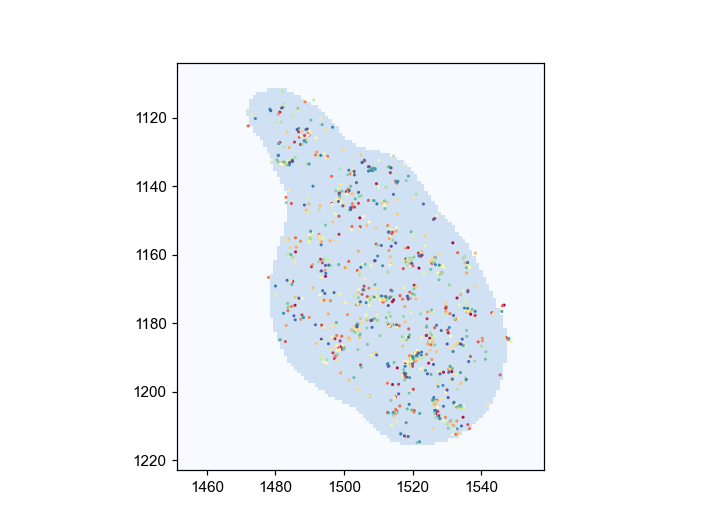

In [186]:
from matplotlib.cm import Reds, Blues, Spectral
fig, ax = plt.subplots()
ax.imshow(aire_mask.max(0), cmap='Blues', vmin=0, vmax=5)
#ax.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=40000)
ax.scatter(_coords2, _coords1,cmap=Spectral, 
        c=_class_ids, s=1)

ax.set_aspect('equal')
plt.show()

In [ ]:
# generate union of dict
final_info = {}
for _cb, _pairs in sel_pairs_dict.items():

In [31]:
# generate union of dict
final_selected_spots = {_onbit:[] for _onbit in onbits}
for _cb, _pairs in sel_pairs_dict.items():
    final_selected_spots[onbits[_cb[0]]].append(sel_spots_list[_cb[0]][_pairs[0]])
    final_selected_spots[onbits[_cb[1]]].append(sel_spots_list[_cb[1]][_pairs[1]])
final_selected_spots = {_k:np.concatenate(_v) for _k,_v in final_selected_spots.items()}

In [32]:
final_selected_spots

{7: array([[ 2.25050996e+04,  4.76882935e+00,  2.78788300e+02,
          5.80751404e+02,  1.04438242e+04,  1.41999388e+00,
          1.65844154e+00,  1.34955955e+00,  7.10394531e-02,
          2.28223100e-01,  7.68200684e+02],
        [ 1.68962500e+04,  7.11169910e+00,  1.16197461e+03,
          1.52540430e+03,  9.41935645e+03,  1.37912834e+00,
          1.30772138e+00,  1.88046575e+00, -4.21388865e-01,
         -4.51825351e-01,  5.77921509e+02],
        [ 5.76200293e+03,  1.89868336e+01,  8.33432739e+02,
          1.37261353e+03,  9.19002441e+03,  1.66383076e+00,
          2.93246245e+00,  1.37993884e+00,  5.35120904e-01,
          6.29943490e-01,  5.33839905e+02],
        [ 2.98487671e+03,  3.53055687e+01,  1.59036243e+03,
          1.95827844e+03,  7.76029590e+03,  2.89860964e+00,
          3.00541806e+00,  2.04170752e+00, -1.00000000e+00,
          6.05744004e-01,  2.78167725e+02],
        [ 1.41793486e+04,  2.37920361e+01,  1.13232837e+03,
          1.48045679e+03,  8.23623828e+03

In [ ]:
from matplotlib.cm import Reds, Blues, Spectral
fig, ax = plt.subplots()
#ax.imshow(aire_mask.max(0), cmap='Blues', vmin=0, vmax=5)
ax.imshow(aire_im.max(0), cmap='Blues', vmin=1000, vmax=30000)
for on
    ax.plot(_left_spots[:,3], _left_spots[:,2], '.', 
            c=Reds(_onbit/len(_code)), markersize=3)


ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


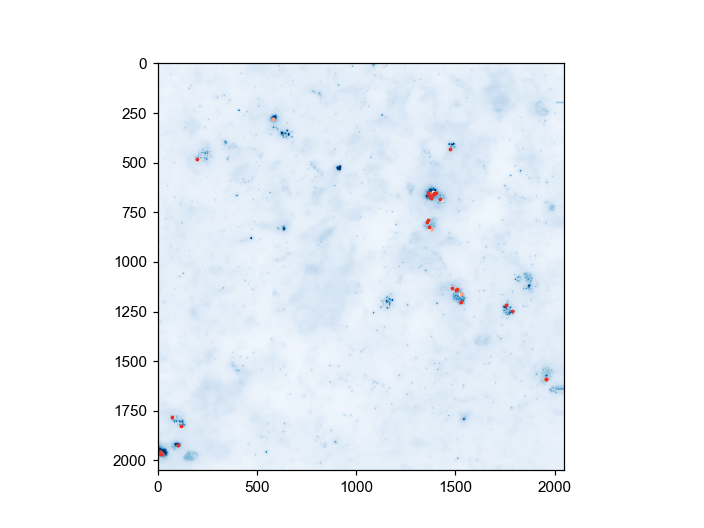

In [27]:
from matplotlib.cm import Reds, Blues, Spectral
fig, ax = plt.subplots()
#ax.imshow(aire_mask.max(0), cmap='Blues', vmin=0, vmax=5)
ax.imshow(aire_im.max(0), cmap='Blues', vmin=1000, vmax=30000)
for _cb, _pairs in sel_pairs_dict.items():
    _left_spots = sel_spots_list[_cb[0]][_pairs[0]]
    _right_spots = sel_spots_list[_cb[1]][_pairs[1]]

    ax.plot(_left_spots[:,3], _left_spots[:,2], '.', 
            c=Reds(_cb[0]/len(sel_hzxys_list)), markersize=3)
    ax.plot(_right_spots[:,3], _right_spots[:,2], '.', 
            c=Reds(_cb[1]/len(sel_hzxys_list)), markersize=3)

ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


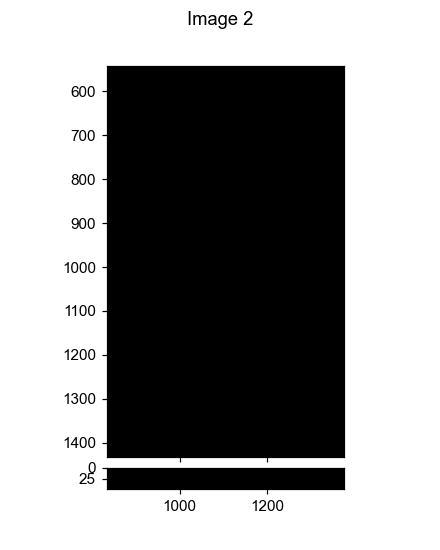

In [50]:
visual_tools.imshow_mark_3d_v2(combo_ims)

<IPython.core.display.Javascript object>


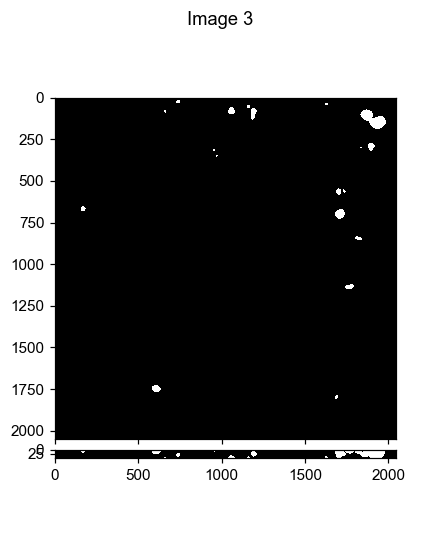

In [13]:
visual_tools.imshow_mark_3d_v2([aire_im, aire_mask, dialated_mask])

In [23]:
_overwrite_image = False
_overwrite_spot = False
# 2. Process image into candidate spots
fov.parallel=True
fov.combo_ref_id = 0
fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _fit_in_mask=True,
                            _fitting_args={'seed_mask':dialated_mask},
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=_overwrite_spot,
                            _verbose=True)


-- No folder selected, allow processing all 26 folders
-- checking combo, region:[1 2] in 0.004s.
-- checking combo, region:[3 4] in 0.003s.
-- checking combo, region:[5 6] in 0.003s.
-- checking combo, region:[7 8] in 0.003s.
-- checking combo, region:[ 9 10] in 0.003s.
-- checking combo, region:[11 12] in 0.003s.
-- checking combo, region:[13 14] in 0.003s.
-- checking combo, region:[15 16] in 0.003s.
-- checking combo, region:[17 18] in 0.003s.
-- checking combo, region:[19 20] in 0.003s.
-- checking combo, region:[21 22] in 0.003s.
-- checking combo, region:[23 24] in 0.003s.
-- checking combo, region:[25 26] in 0.003s.
-- checking combo, region:[27 28] in 0.003s.
-- checking combo, region:[29 30] in 0.003s.
-- checking combo, region:[31 32] in 0.003s.
-- checking combo, region:[33 34] in 0.003s.
-- checking combo, region:[35 36] in 0.003s.
-- checking combo, region:[37 38] in 0.003s.
-- checking combo, region:[39 40] in 0.003s.
-- checking combo, region:[41 42] in 0.003s.
-- check

In [33]:
fov._load_from_file('combo', _overwrite=True)

+ loading combo from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_003.hdf5
++ finish loading combo in 0.009s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1630: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


<IPython.core.display.Javascript object>


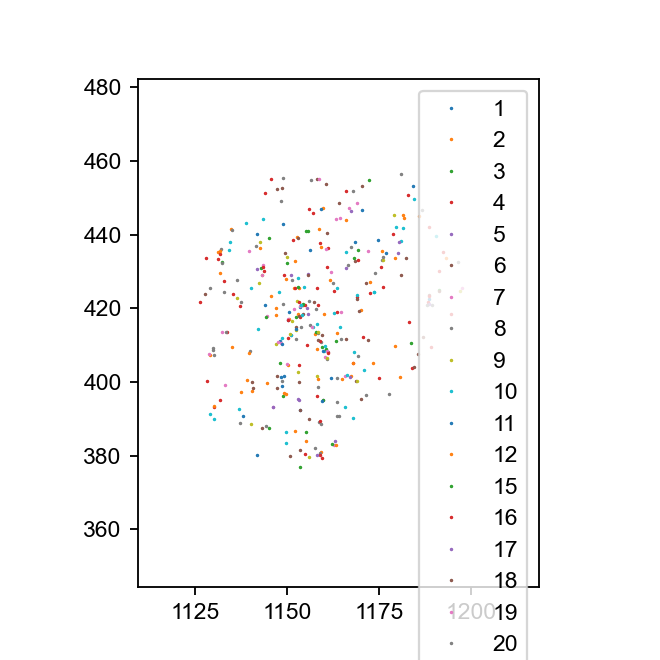

In [34]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
for _id, _spots in zip(fov.combo_ids, fov.combo_spots_list):
    if len(_spots) > 0:
        _sel_spots = _spots[(_spots[:,1] > 25) * (_spots[:,1] <= 35)]
        
        ax.plot(_sel_spots[:,2], _sel_spots[:,3], '.', markersize=1, label=f'{_id}')

ax.set_aspect('equal', 'box')
ax.legend()
plt.show()


In [27]:
# search pairs
zxys_list = [_spots[:,1:4]*fov.shared_parameters['distance_zxy'] for _spots in fov.combo_spots_list]

In [14]:


for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 2. Process image into candidate spots
    fov.combo_ref_id = 0
    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

    # 4. load dapi image
    dapi_im = fov._load_dapi_image(_dapi_id=0)

    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loadi

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_011.dax  in 24.018s
-- removing hot pixels for channels:['561'] in 10.692s
-- correct Z-shifts for channels:['561'] in 8.531s
-- illumination correction for channels: 561, in 3.612s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 48.001s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_011.hdf5
++ base attributes saved:['combo_ref_im'] in 8.597s.
-- checking combo, region:[1 2] in 0.006s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.005s.
us

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_012.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_012.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_012.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522

-- removing hot pixels for channels:['561'] in 10.147s
-- correct Z-shifts for channels:['561'] in 8.285s
-- illumination correction for channels: 561, in 3.160s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 47.999s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_013.hdf5
++ base attributes saved:['combo_ref_im'] in 8.117s.
-- checking combo, region:[1 2] in 0.004s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.004s.
used_channels: ['750', '647', '561']
-- checking c

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_014.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'co

-- illumination correction for channels: 561, in 2.646s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 38.472s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
++ base attributes saved:['protein_ref_im'] in 7.865s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['

++ base attributes saved:['combo_ref_im'] in 8.104s.
-- checking combo, region:[1 2] in 0.005s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[15 16] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[17 18] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[19 20] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[21 22] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[23 24] in 0.004s.
u

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_016.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

++ processed protein ids: [1 2] + batch process image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_016.hdf5 in 0.613s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax  in 21.912s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 42.538s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 31.094s
-- bleedthrough correction for channels: ['750', '647'] in 11.635s
-- illumination correction for channels: 750, 647, 488, 561, in 12.403s
-- apply bead_drift calculate for channel: 561
-- start a

 49 50] , finish in 406.48s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_017.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_017.dax  in 10.677s
-- removing hot pixels for channels:['405'] in 13.130s
-- correct Z-shifts for channels:['405'] in 8.995s
-- illumination correction for channels: 405, in 3.841s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 37.814s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_017.hdf5
++ base attributes saved:['dapi_im'] in 7.940s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
--- combo attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
save type: protein"
-- saving protein to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
--- protein attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_018.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_018.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x20

-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.561s
-- update drift of H25P1\Conv_zscan_018.dax into file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\drift\Conv_zscan_018_current_cor.pkl
in 372.80s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ loa

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax  in 11.713s
-- removing hot pixels for channels:['405'] in 12.981s
-- correct Z-shifts for channels:['405'] in 7.459s
-- illumination correction for channels: 405, in 2.693s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 35.861s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5
++ base attributes saved:['dapi_im'] in 7.885s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_W

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax  in 6.910s
-- removing hot pixels for channels:['561'] in 10.092s
-- correct Z-shifts for channels:['561'] in 8.006s
-- illumination correction for channels: 561, in 2.957s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 28.851s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_020.hdf5
++ base attributes saved:['combo_ref_im'] in 7.991s.
-- checking combo, region:[1 2] in 0.004s.
used_ch

dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_021.dax  in 16.525s
-- removing hot pixels for channels:['561'] in 9.145s
-- correct Z-shifts for channels:['561'] in 7.272s
-- illumination correction for channels: 561, in 2.673s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 36.845s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_021.hdf5
++ base attributes saved:['protein_ref_im'] in 7.832s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_023.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'co

-- illumination correction for channels: 561, in 2.928s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 23.895s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
++ base attributes saved:['protein_ref_im'] in 7.650s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['

-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ base attributes saved:['combo_ref_im'] in 7.558s.
-- checking combo, region:[1 2] in 0.004s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[15 16] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[17 18] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[19 20] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[21

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_025.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

- loading protein info from file:Conv_zscan_025.hdf5 in 0.596s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_025.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_025.dax  in 8.661s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 41.958s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 30.642s
-- bleedthrough correction for channels: ['750', '647'] in 10.546s
-- illumination correction for channels: 750, 647, 488, 561, in 11.693s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
--- align image 0 in 8.050s.
--- align image 1 in 7.978s.
--- align image 2 in 8.123s.
--- drifts for crops:[0 1 2] pass th

 49 50] , finish in 387.96s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_026.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_026.dax  in 7.437s
-- removing hot pixels for channels:['405'] in 12.026s
-- correct Z-shifts for channels:['405'] in 8.881s
-- illumination correction for channels: 405, in 4.045s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.358s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_026.hdf5
++ base attributes saved:['dapi_im'] in 8.079s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5
--- combo attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
save type: protein"
-- saving protein to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5
--- protein attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_027.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_027.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x20

-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.868s
-- update drift of H25P1\Conv_zscan_027.dax into file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\drift\Conv_zscan_027_current_cor.pkl
in 369.30s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ loa

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax  in 5.571s
-- removing hot pixels for channels:['561'] in 9.166s
-- correct Z-shifts for channels:['561'] in 7.119s
-- illumination correction for channels: 561, in 2.703s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 25.440s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5
++ base attributes saved:['combo_ref_im'] in 8.069s.
-- checking combo, region:[1 2] in 0.004s.
used_cha

In [9]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]

In [10]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['protein']
    protein_ims = _grp['ims'][:]
    protein_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


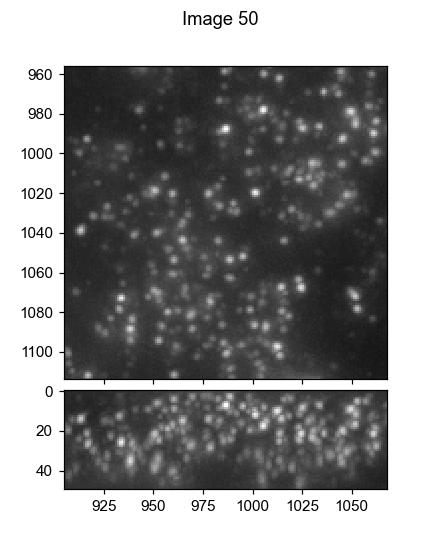

In [11]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([protein_ims[0]]+list(combo_ims))
